# **(Feature Engineering Notebook)**

## Objectives

* Engineer features for Regression models

## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Creating a Compilation of Features for Engineering.

## Additional Comments

* I followed the steps taken in the walkthrough project by code institute and also github.com/amareteklay. Some part are directly taken from code institute.


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [19]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/housepricepred2'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [20]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [21]:
current_dir = os.getcwd()
current_dir

'/workspace'

## Load Cleaned Data

* Start with Train set

In [22]:
import pandas as pd 
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head()

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/datasets/cleaned/TrainSetCleaned.csv'

* Then we load the Train set

In [ ]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
0      2515       0.0           4.0           No        1219          Rec   
1       958     620.0           3.0           No         403          BLQ   
2       979     224.0           3.0           No         185          LwQ   
3      1156     866.0           4.0           No         392          BLQ   
4       525       0.0           3.0           No           0          Unf   

   BsmtUnfSF  GarageArea GarageFinish  GrLivArea  ... LotArea  LotFrontage  \
0        816         484          Unf       2515  ...   32668     71.75102   
1        238         240          Unf       1578  ...    9490     79.00000   
2        524         352          Unf       1203  ...    7015     71.75102   
3        768         505          Fin       2022  ...   10005     83.00000   
4        525         264          Unf       1092  ...    1680     21.00000   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0         0.0            0            3            6         2035       1957   
1         0.0            0            7            6          806       1941   
2       161.0            0            4            5          709       1950   
3       299.0          117            5            7         1160       1977   
4       381.0            0            5            6          525       1971   

   YearRemodAdd  SalePrice  
0          1975     200624  
1          1950     133000  
2          1950     110000  
3          1977     192000  
4          1971      88000  

[5 rows x 21 columns]

* Then we check and display missing values in Train/Test set

In [ ]:
missing_values_train = TrainSet.isnull().sum()
missing_values_train = missing_values_train[missing_values_train > 0]
print("Missing values in Train Set (only columns with missing values):")
print(missing_values_train)

missing_values_test = TestSet.isnull().sum()
missing_values_test = missing_values_test[missing_values_test > 0]
print("\nMissing values in Test Set (only columns with missing values):")
print(missing_values_test)

Missing values in Train Set (only columns with missing values):
Series([], dtype: int64)

Missing values in Test Set (only columns with missing values):
Series([], dtype: int64)


## Data Exploaration

* We generat a pandas profiling report, by doing that we get a comprehensive overview of our dataset, which can be extremely useful for initial data exploration and identifying data quality issues like missing values, potential errors, and understanding the distribution of the data.

In [ ]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* In the raport we can see there is many skewed, outliers and some with many zero

## Feature Engineering

### Custum functions

In [ ]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop in each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng,list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing value in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(4, 3))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show()
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.tight_layout()
  plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked

### 1. Ordinal categorical encoding

In [ ]:
# Selected variables for focused feature engineering
selected_features = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

# Creating a DataFrame specifically for feature engineering
df_eng = TrainSet[selected_features].copy()

# Displaying the first few entries to verify the content
print("Initial Data for Feature Engineering:")
df_eng.head()

Initial Data for Feature Engineering:


BsmtExposure BsmtFinType1 GarageFinish KitchenQual
0           Av          Unf          Unf          Gd
1           No          Unf          Unf          TA
2           No          ALQ          Unf          TA
3           No          GLQ          RFn          Gd
4           No          Unf          RFn          Gd

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



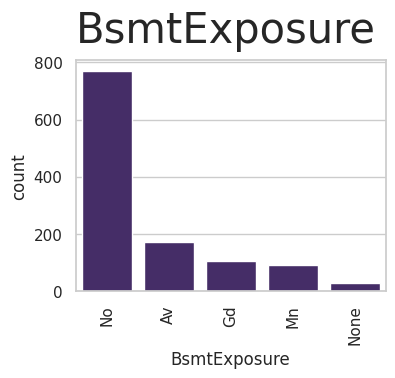

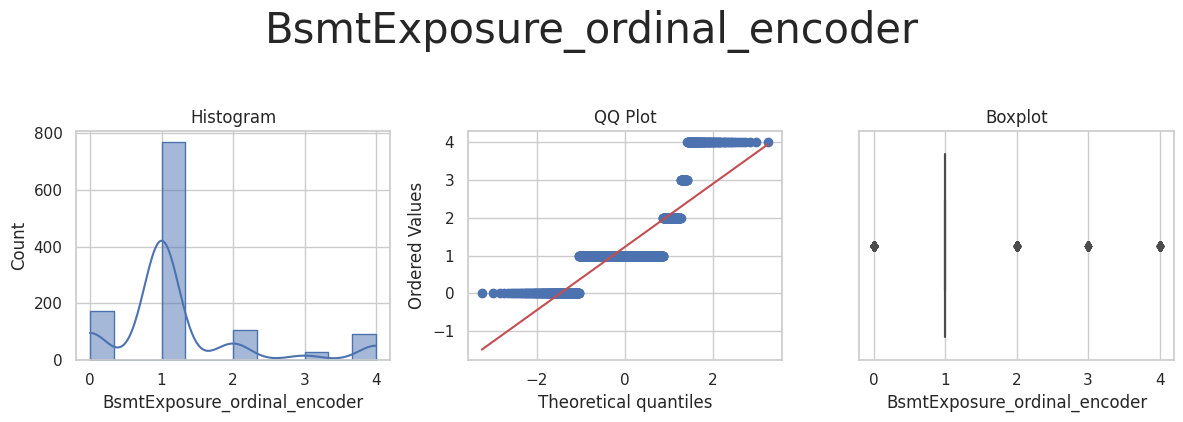



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



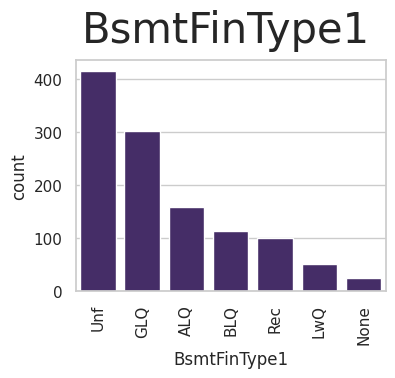

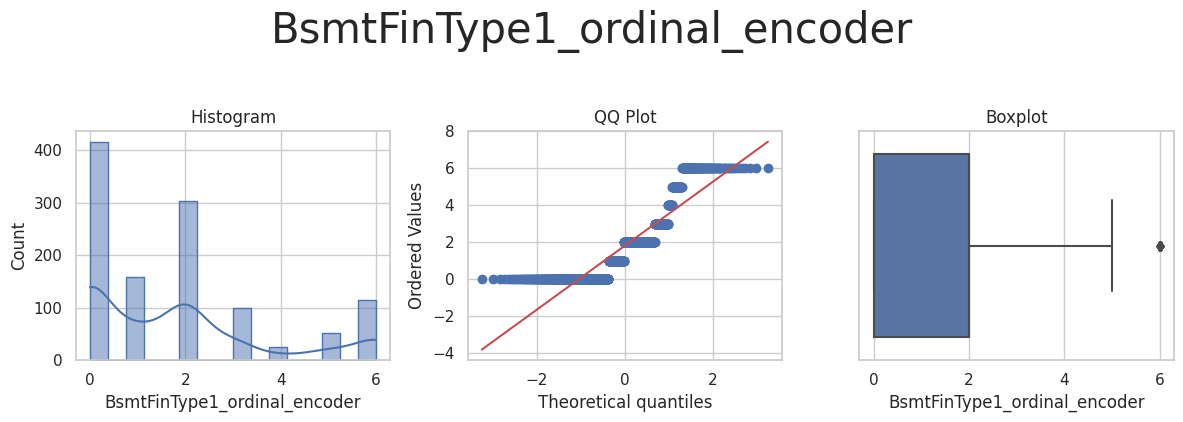



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



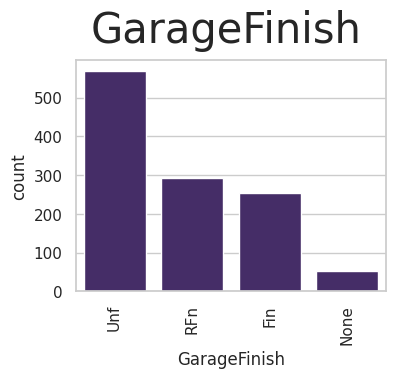

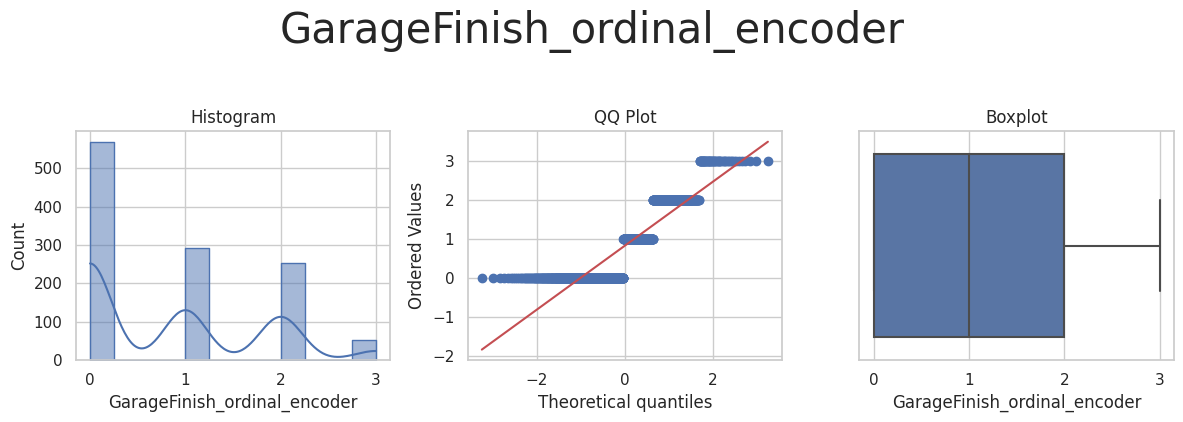



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



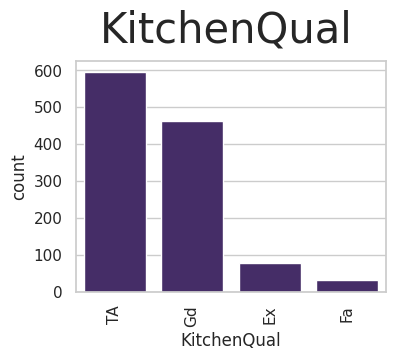

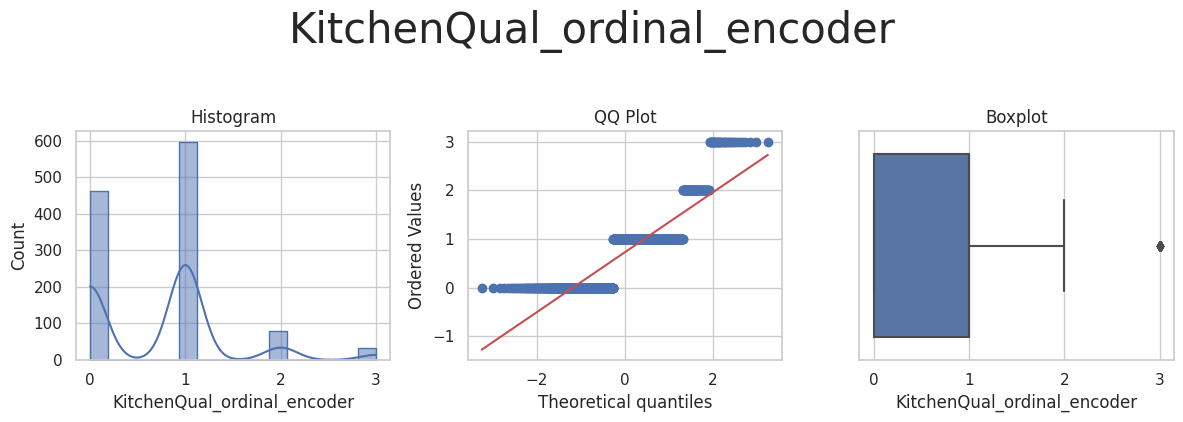

In [ ]:
df_eng = FeatureEngineeringAnalysis(df=df_eng, analysis_type='ordinal_encoder')

We need to apply the transformitions to the test and train set

In [ ]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = selected_features)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.fit_transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


In [ ]:
TrainSet.filter(selected_features).head(3)

BsmtExposure  BsmtFinType1  GarageFinish  KitchenQual
0             0             0             0            0
1             1             0             0            1
2             1             1             0            1

In [ ]:
TestSet.filter(selected_features).head(3)

BsmtExposure  BsmtFinType1  GarageFinish  KitchenQual
0             0             0             0            0
1             0             1             0            1
2             0             2             0            2

### Numerical Transformation

In [ ]:
numerical_trans = ['GrLivArea',
                         'LotArea',
                         'LotFrontage',
                         'GarageArea',
                         'MasVnrArea', 
                         'OpenPorchSF',
                         'TotalBsmtSF',
                         '1stFlrSF',
                         '2ndFlrSF']
                          
numerical_trans

['GrLivArea',
 'LotArea',
 'LotFrontage',
 'GarageArea',
 'MasVnrArea',
 'OpenPorchSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF']

* The second step we take is to create a separete dataframe, we use the var we choose for this

In [ ]:
df_eng = TrainSet[numerical_trans].copy()
df_eng.head()

GrLivArea  LotArea  LotFrontage  GarageArea  MasVnrArea  OpenPorchSF  \
0       1828    11694    90.000000         774       452.0          108   
1        894     6600    60.000000         308         0.0            0   
2        964    13360    80.000000         432         0.0            0   
3       1689    13265    69.614017         857       148.0           59   
4       1541    13704   118.000000         843       150.0           81   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  
0         1822      1828       0.0  
1          894       894       0.0  
2          876       964       0.0  
3         1568      1689       0.0  
4         1541      1541       0.0

* We use the transformitions to create engineered variables we then asses the variables and selects the most sutible method.

* Variable Analyzed: GrLivArea
* Applied transformation: ['GrLivArea_log_e', 'GrLivArea_log_10', 'GrLivArea_reciprocal', 'GrLivArea_power', 'GrLivArea_box_cox', 'GrLivArea_yeo_johnson'] 



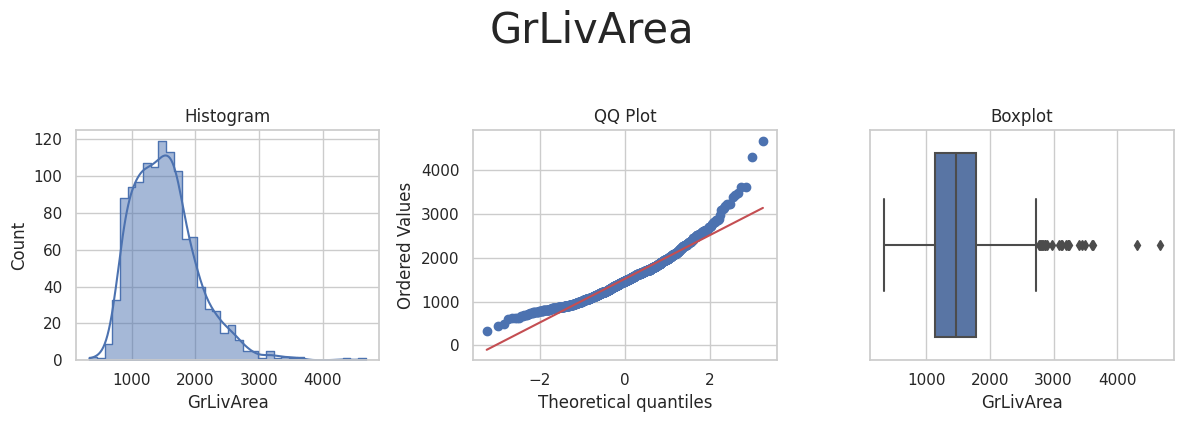

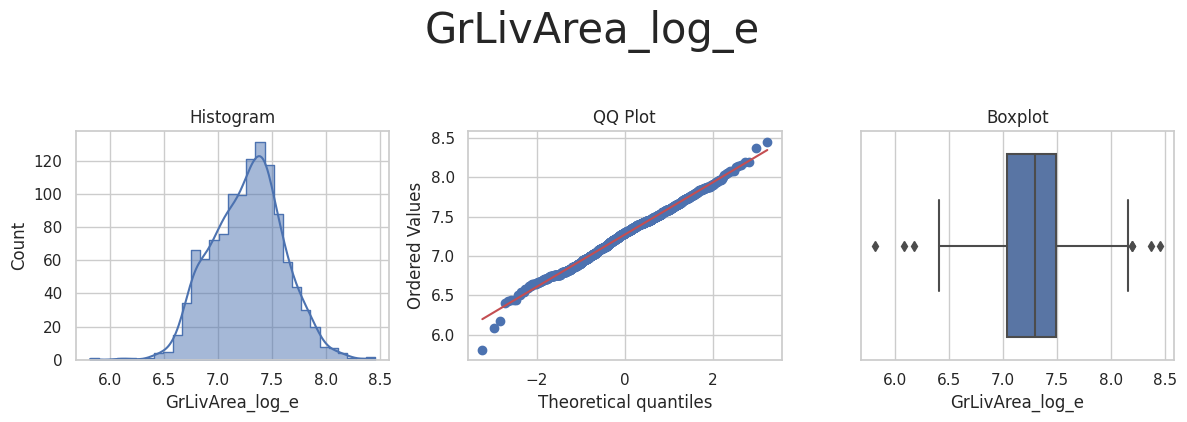

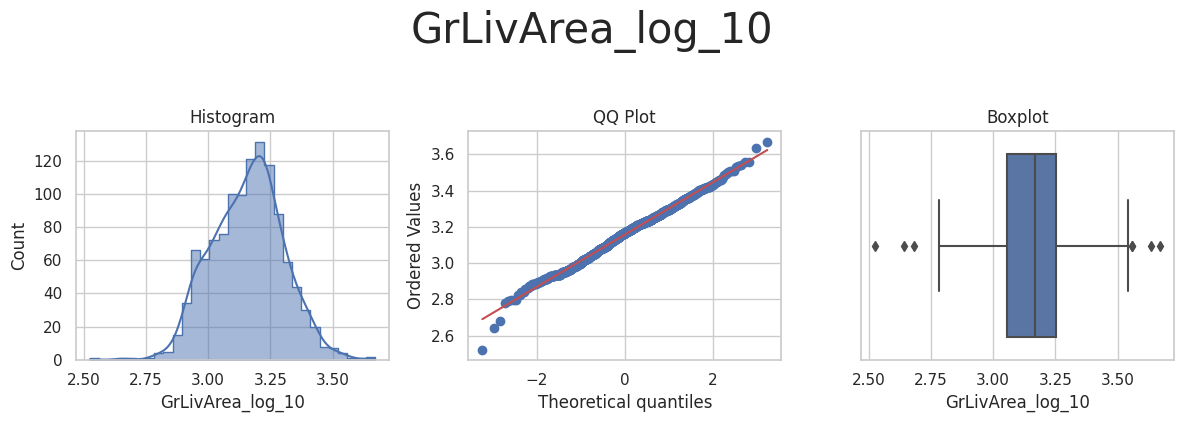

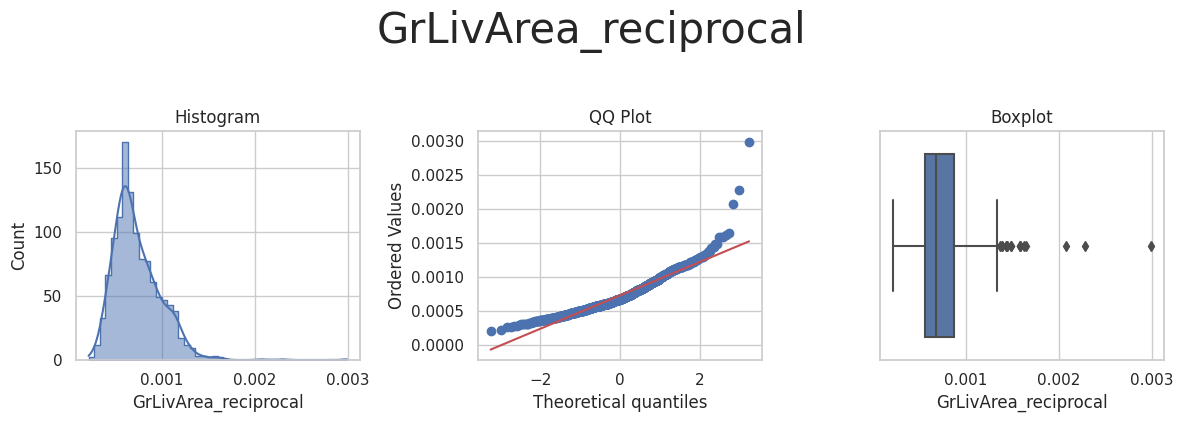

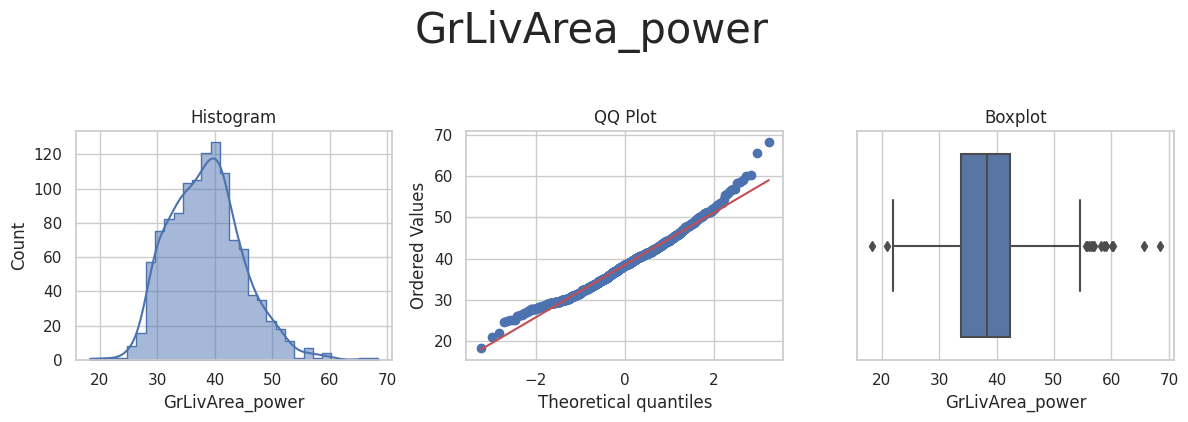

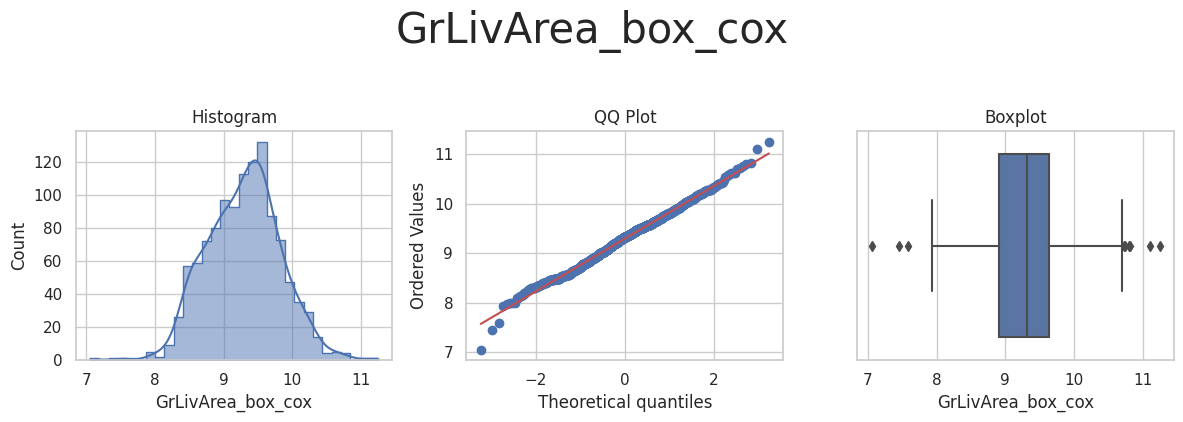

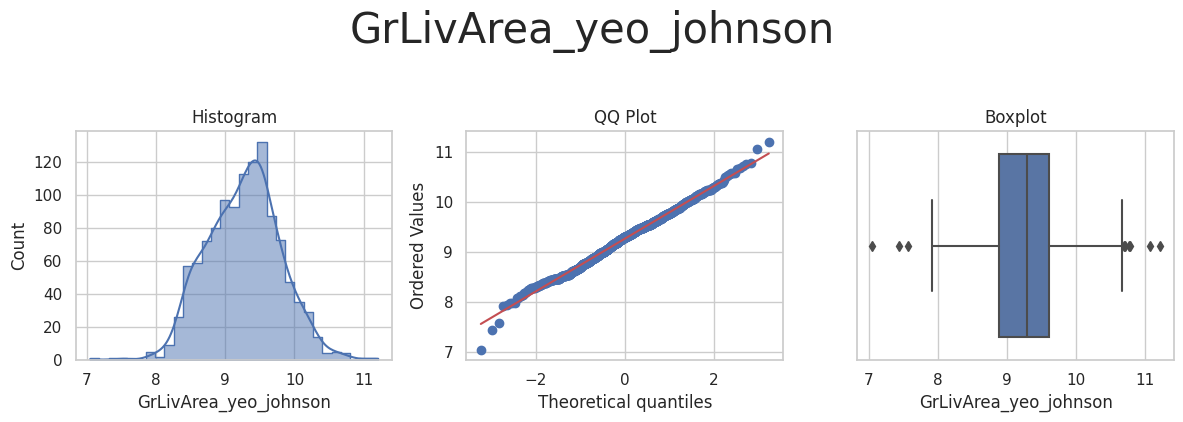



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_log_e', 'LotArea_log_10', 'LotArea_reciprocal', 'LotArea_power', 'LotArea_box_cox', 'LotArea_yeo_johnson'] 



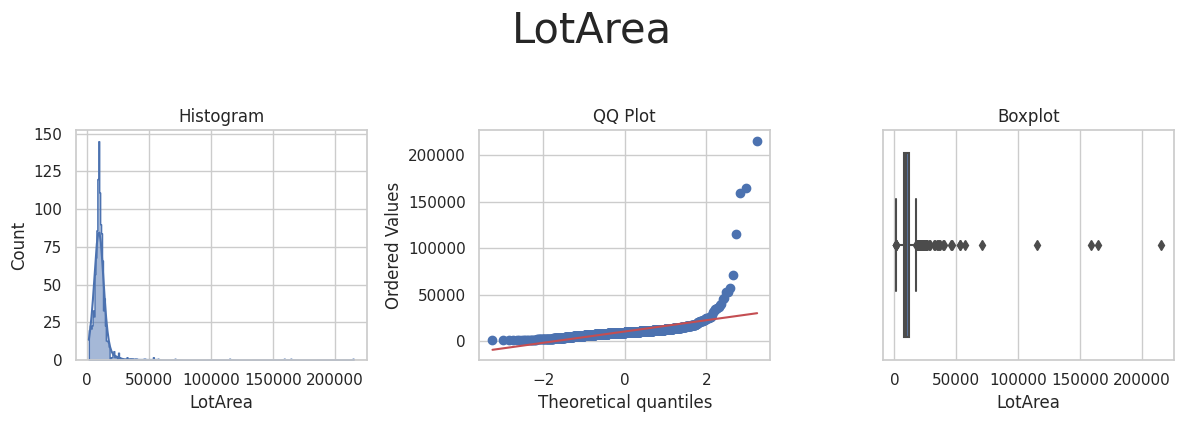

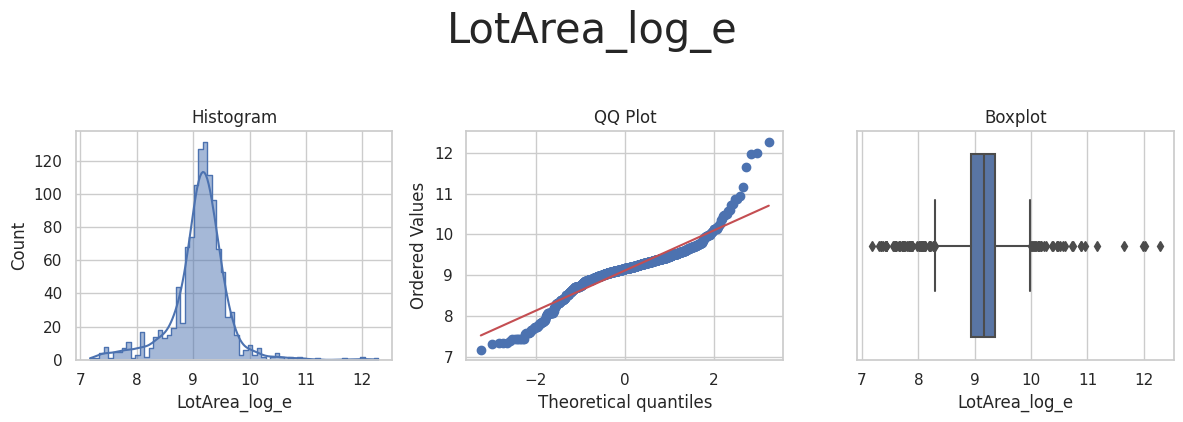

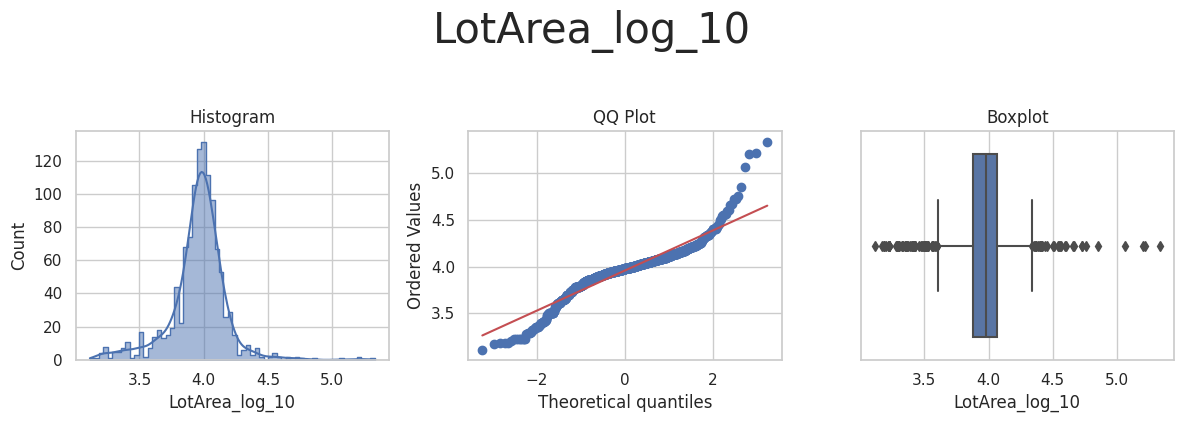

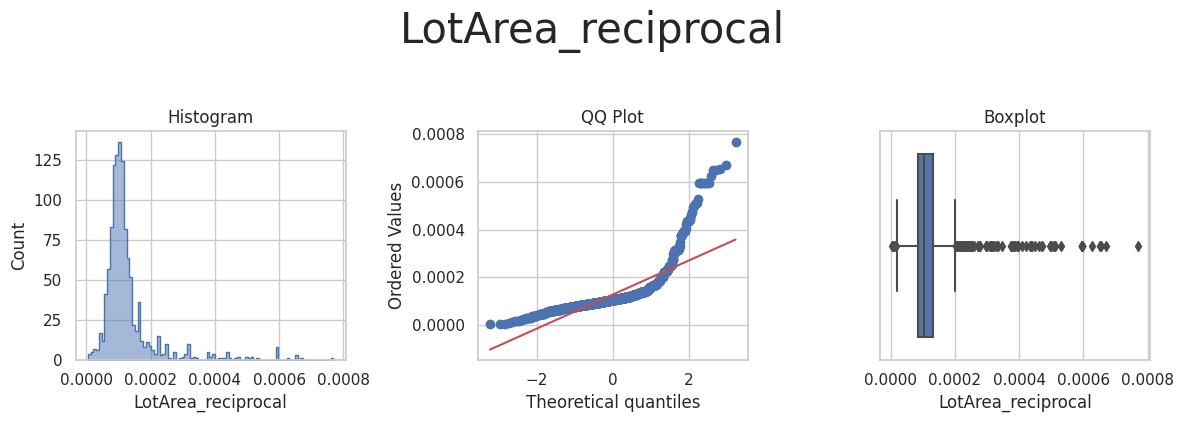

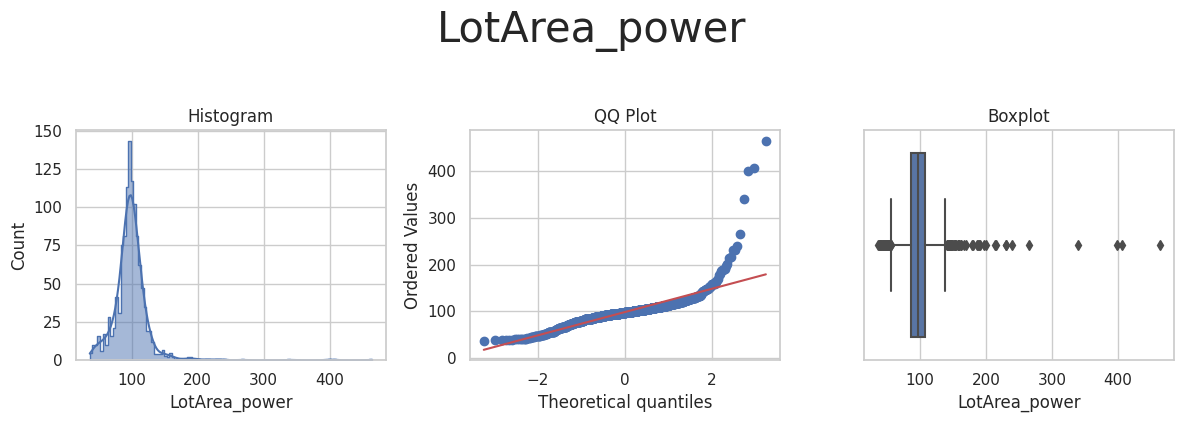

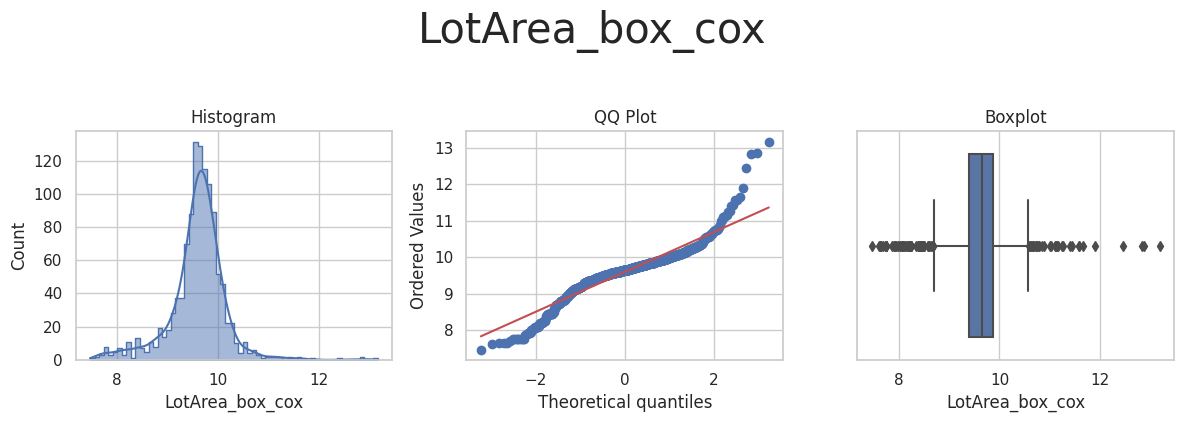

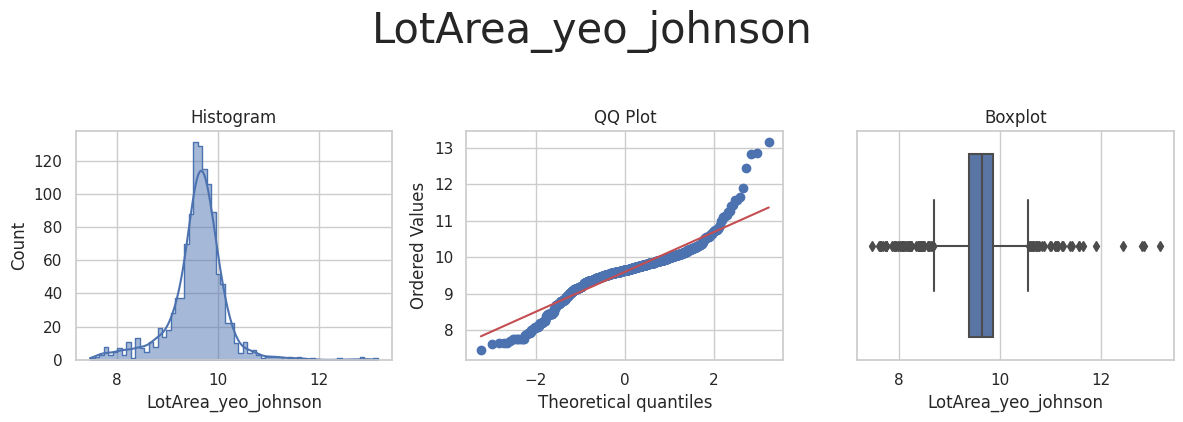



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_log_e', 'LotFrontage_log_10', 'LotFrontage_reciprocal', 'LotFrontage_power', 'LotFrontage_box_cox', 'LotFrontage_yeo_johnson'] 



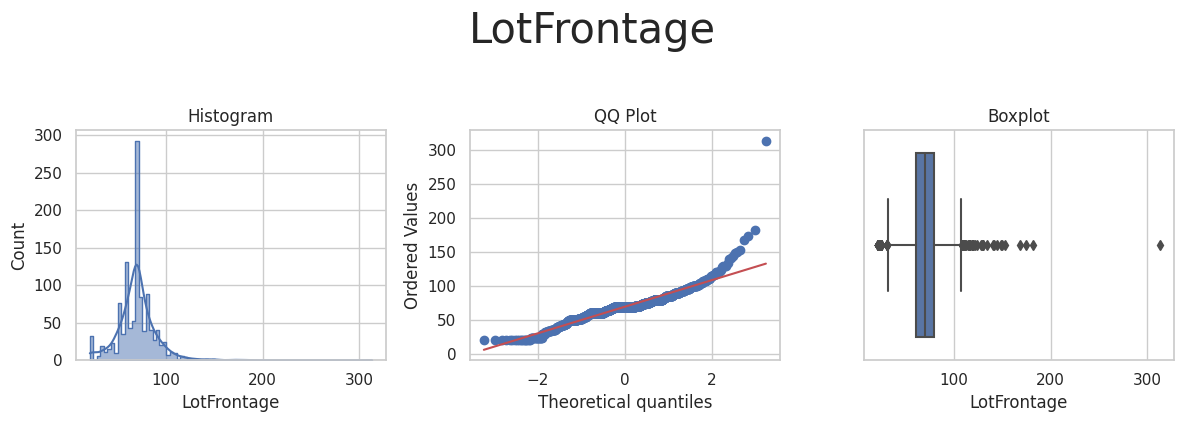

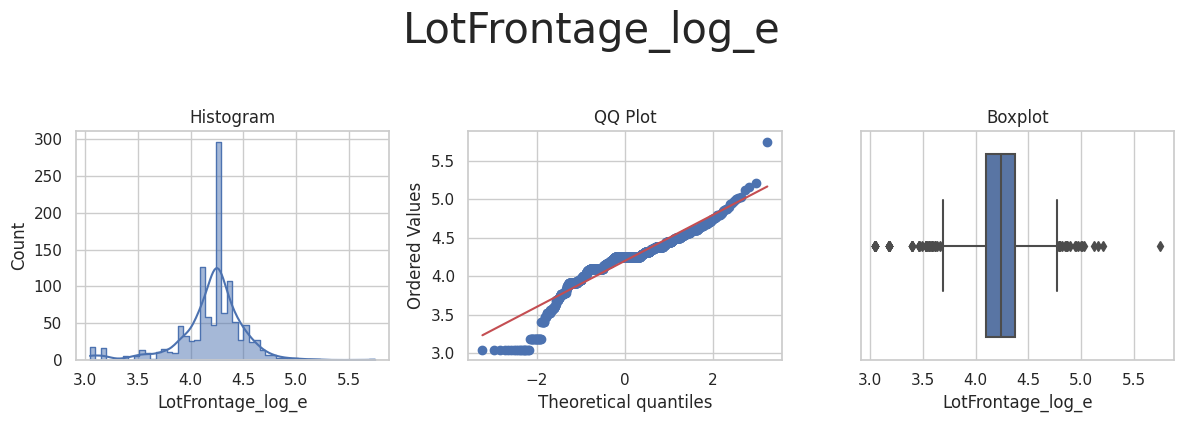

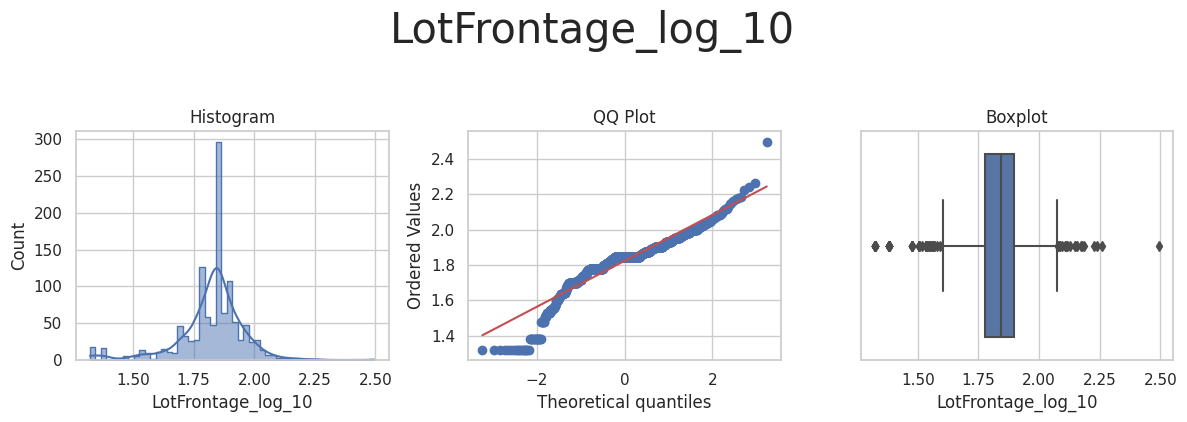

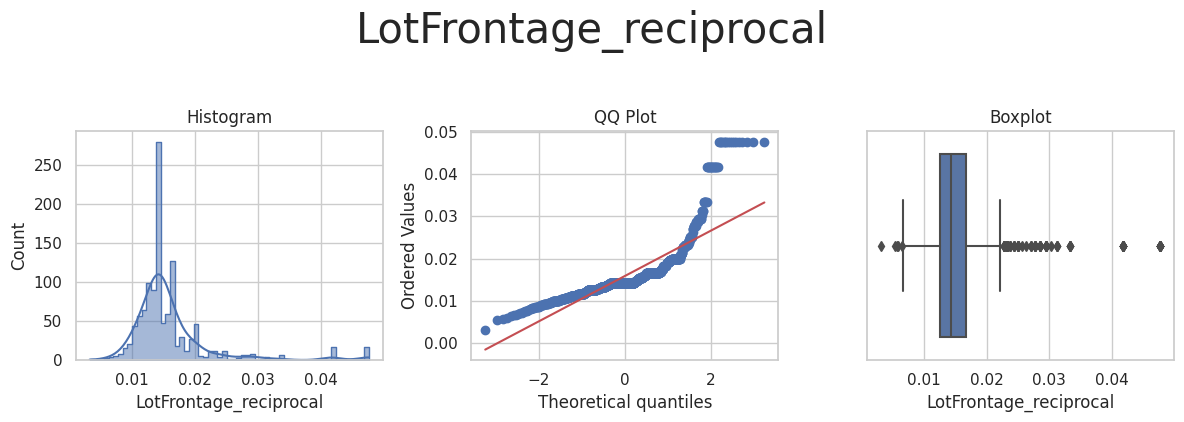

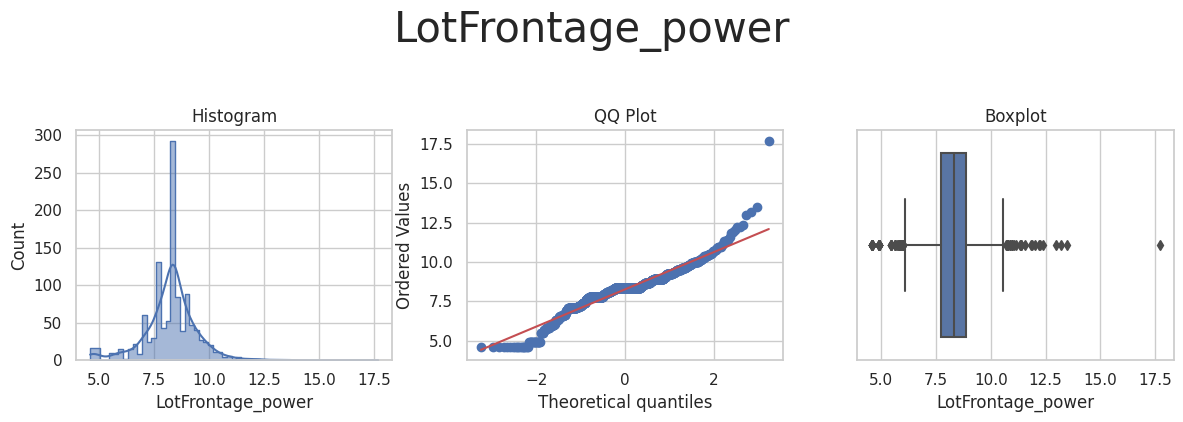

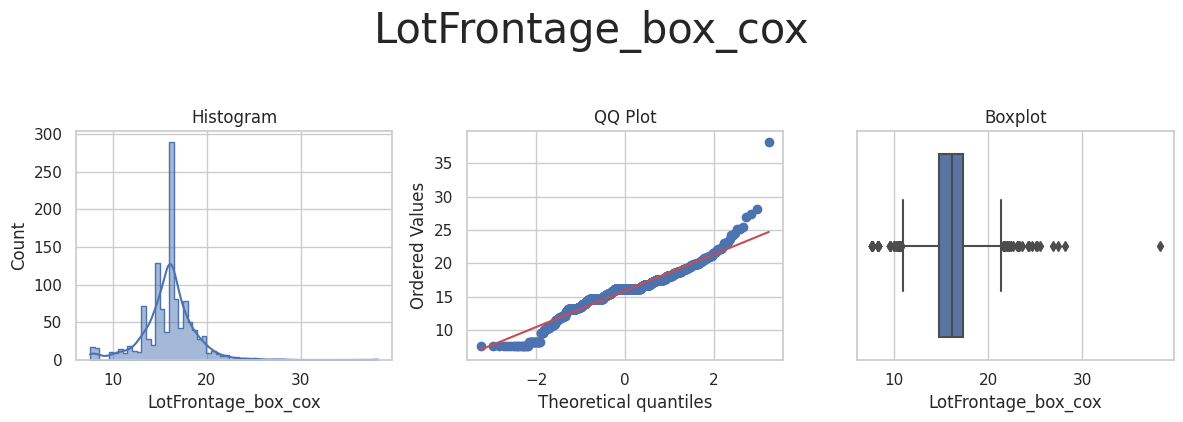

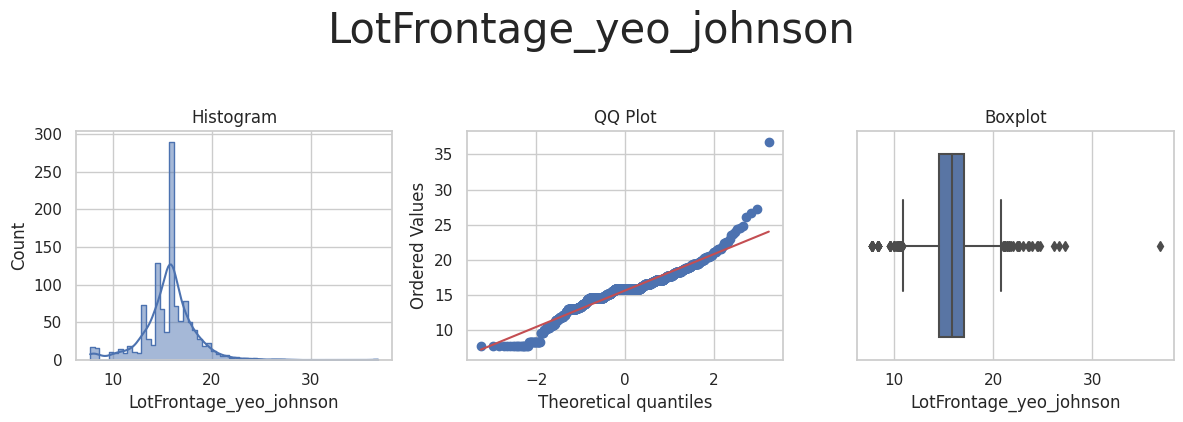



* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_power', 'GarageArea_yeo_johnson'] 



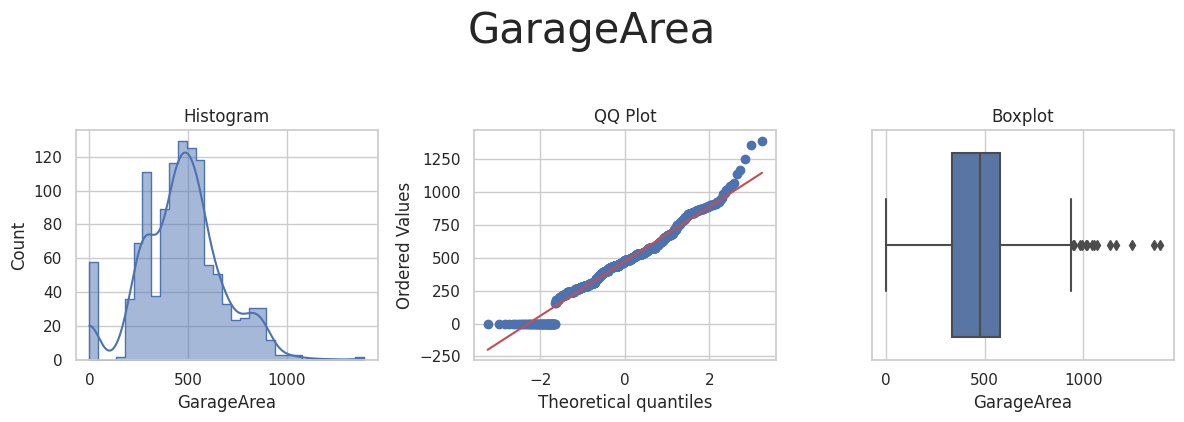

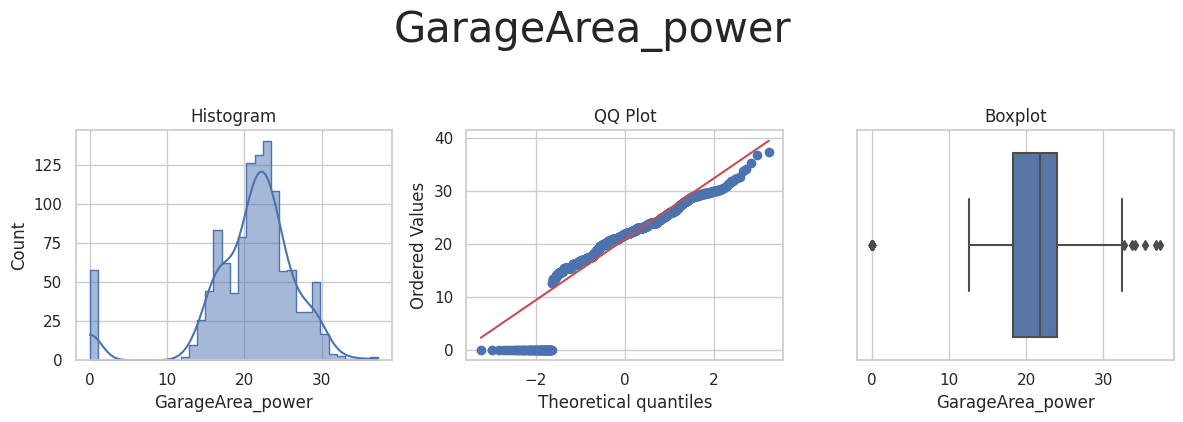

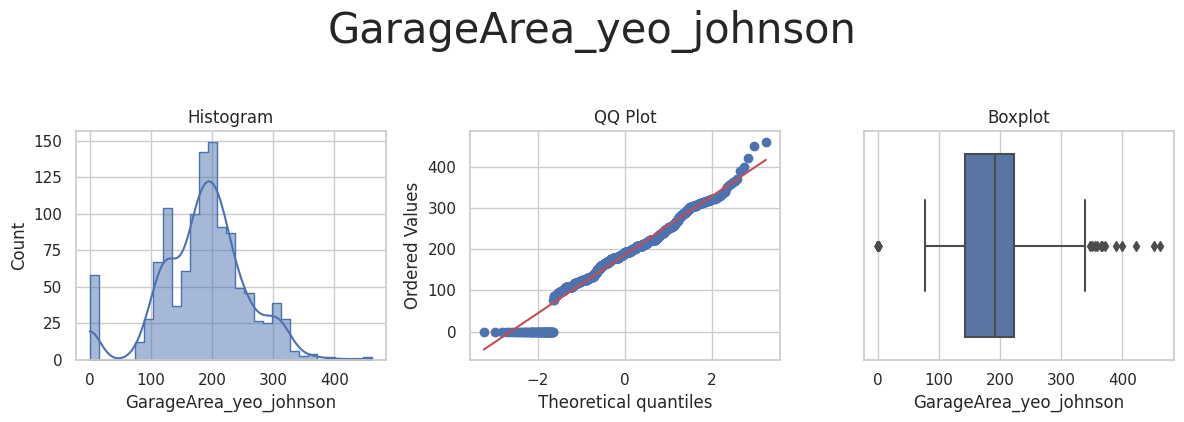



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_power', 'MasVnrArea_yeo_johnson'] 



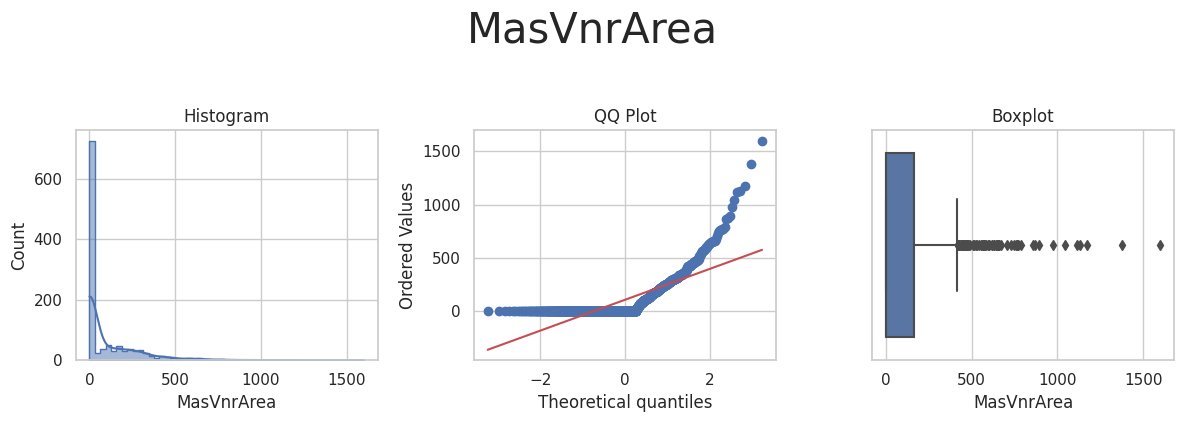

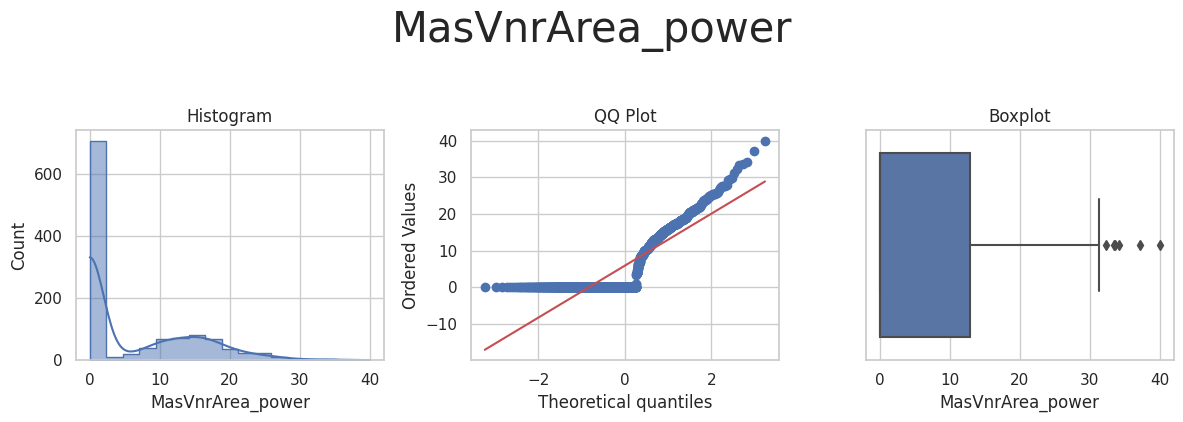

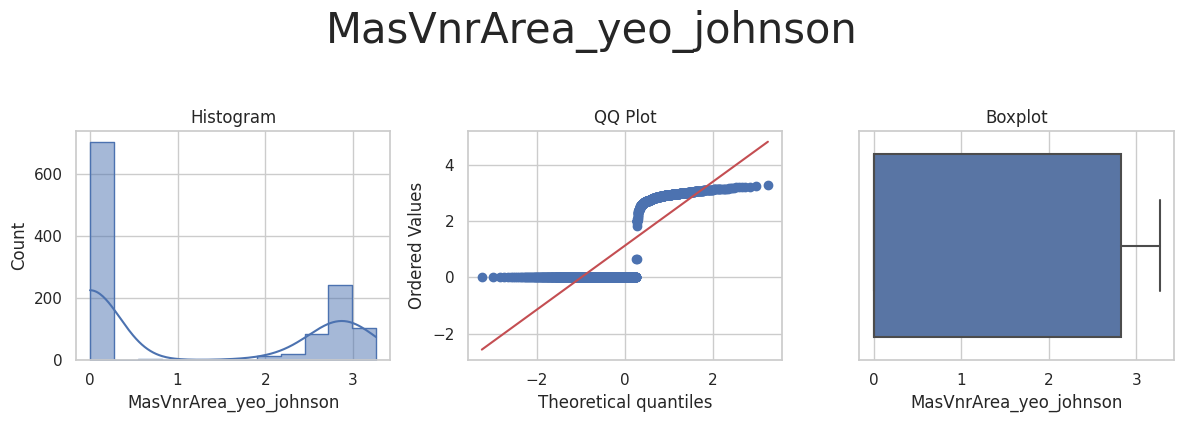



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_power', 'OpenPorchSF_yeo_johnson'] 



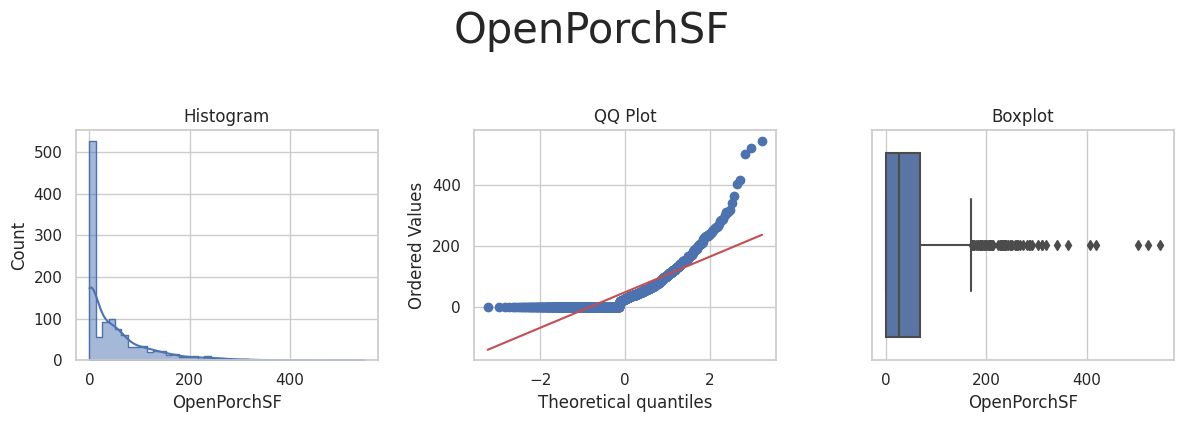

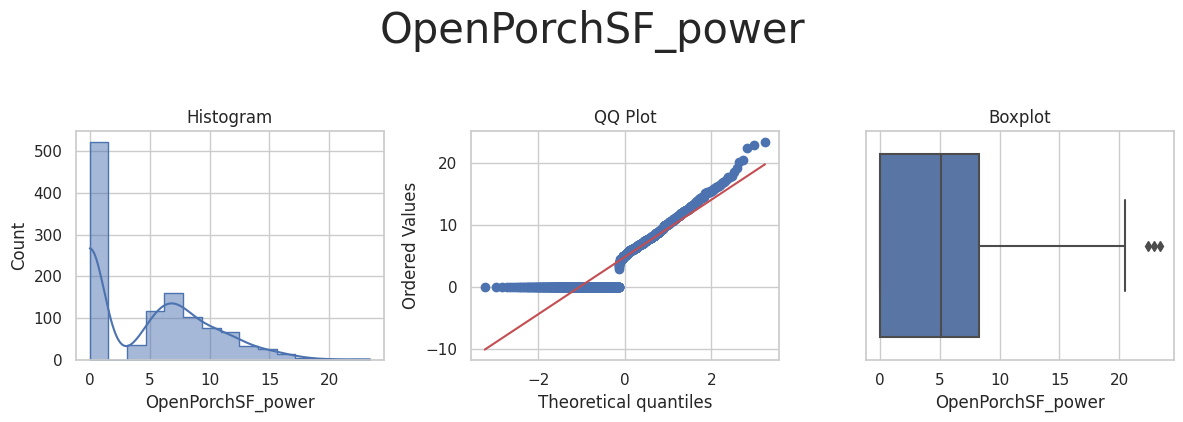

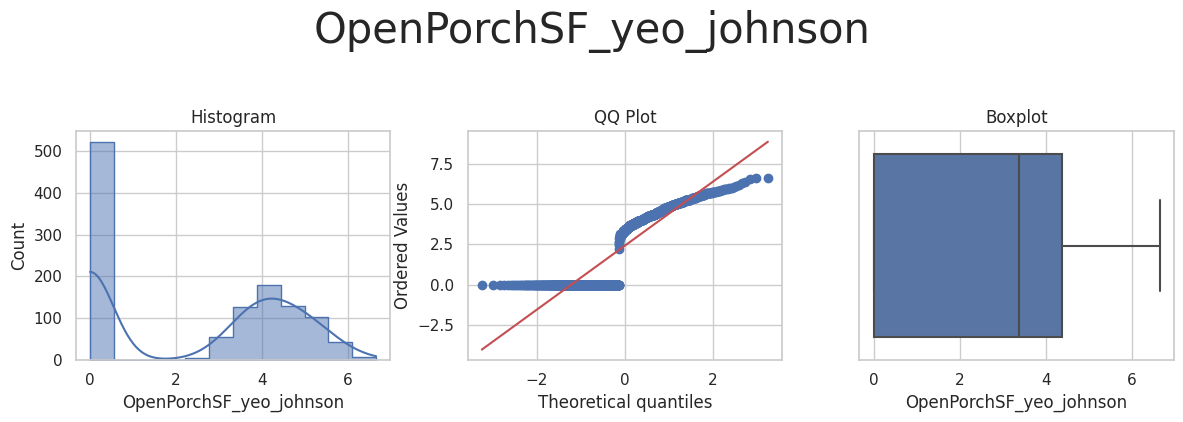



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_power', 'TotalBsmtSF_yeo_johnson'] 



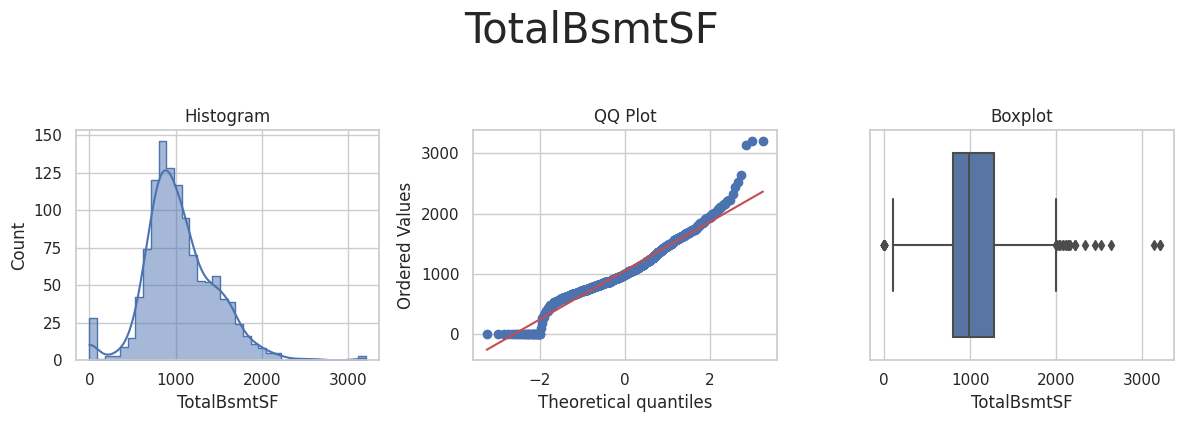

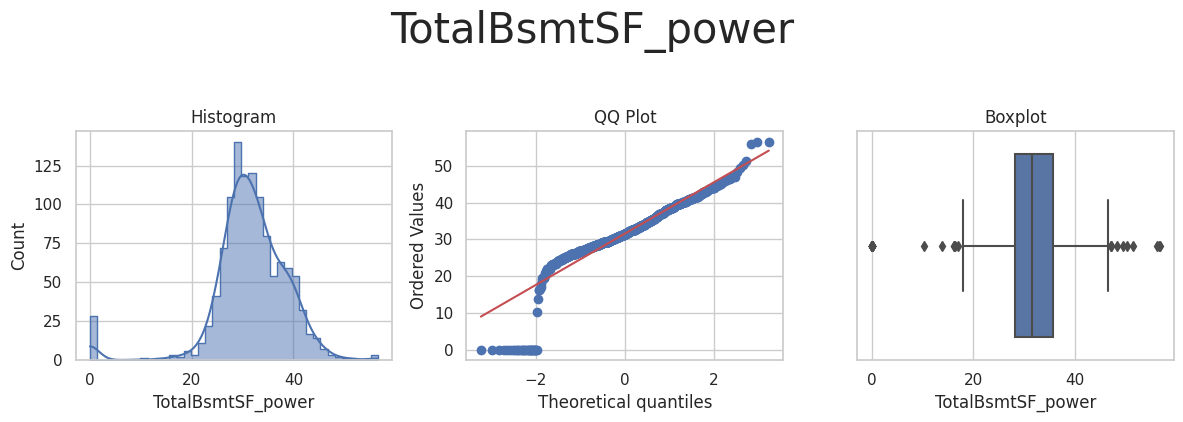

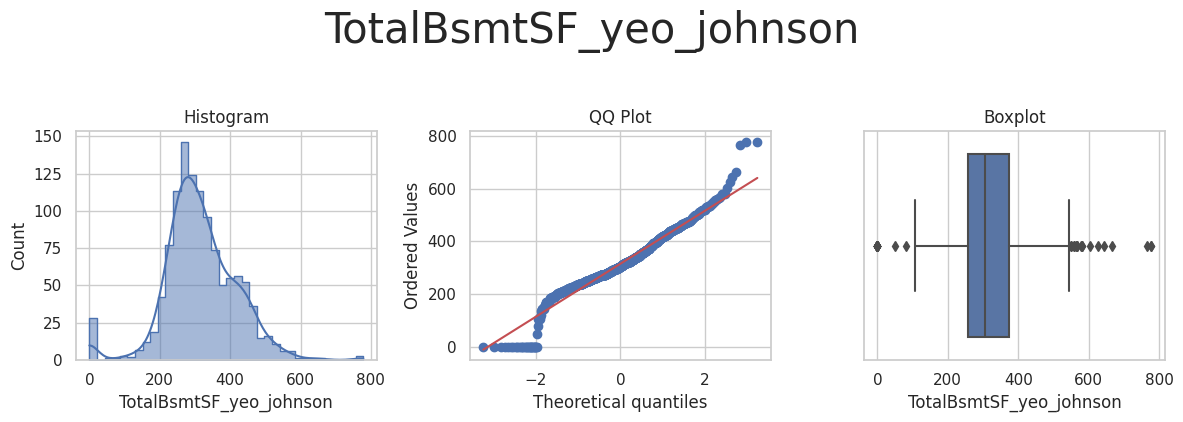



* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_log_e', '1stFlrSF_log_10', '1stFlrSF_reciprocal', '1stFlrSF_power', '1stFlrSF_box_cox', '1stFlrSF_yeo_johnson'] 



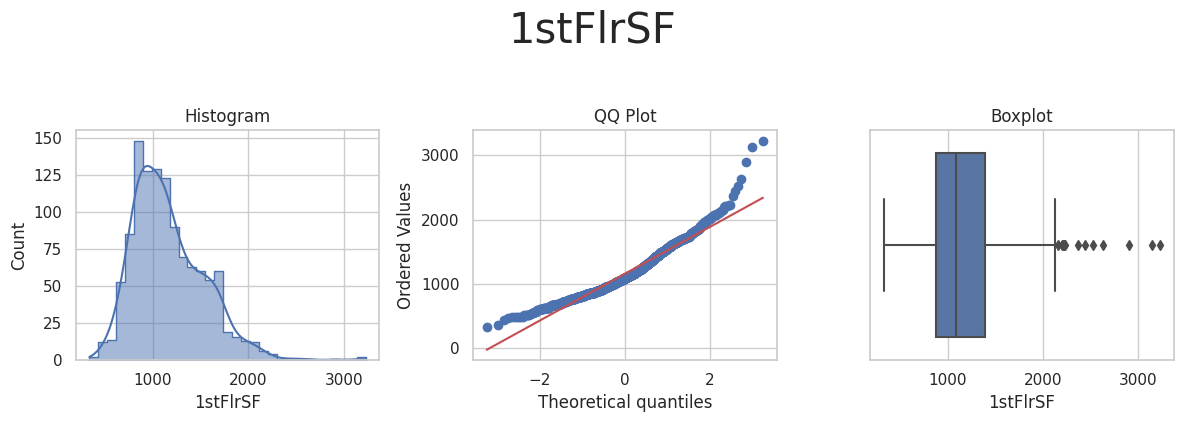

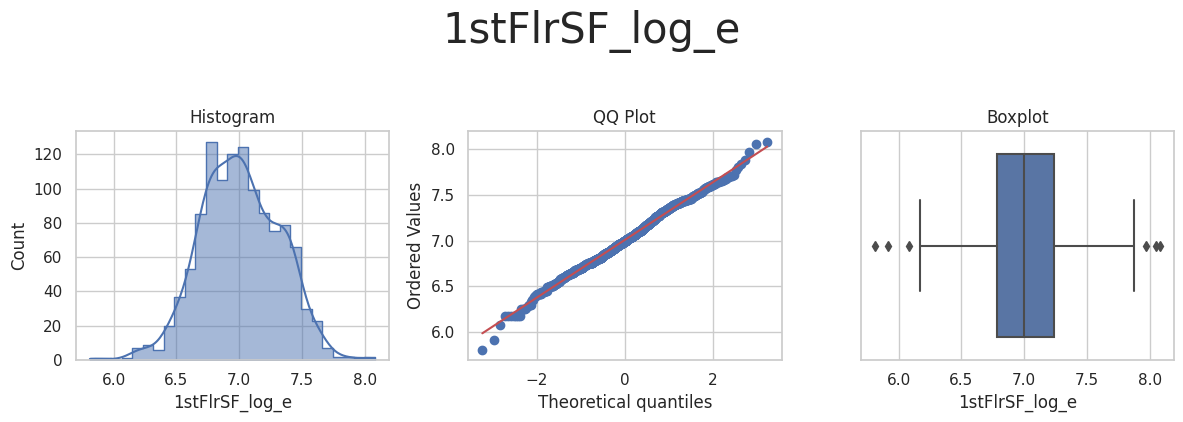

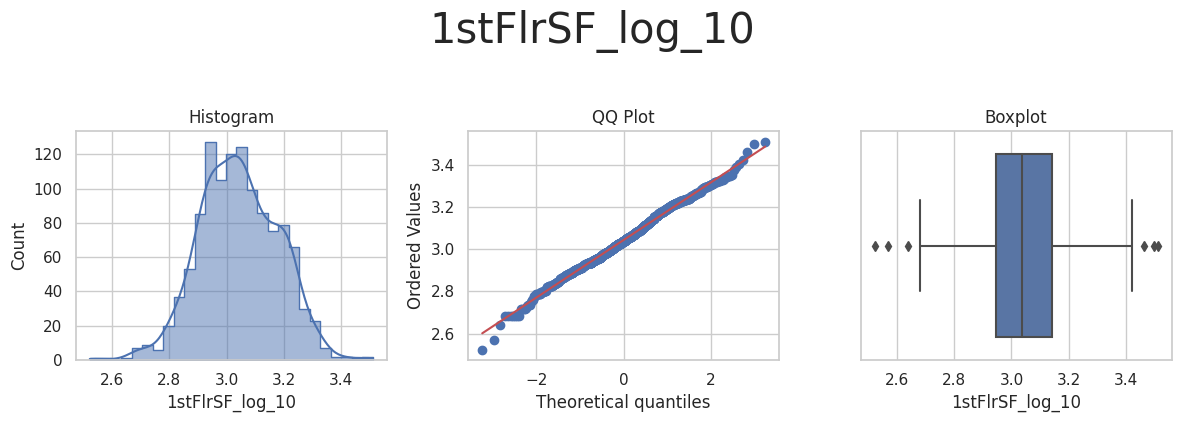

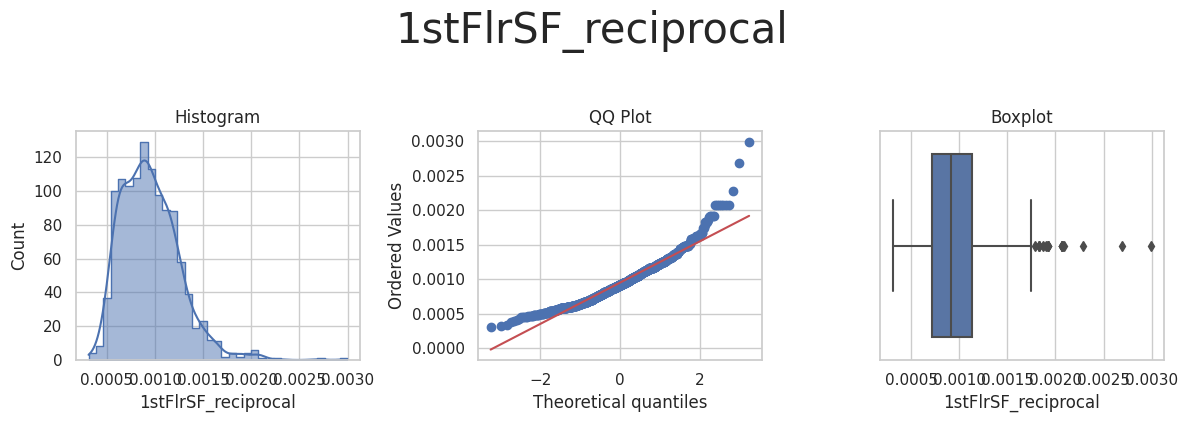

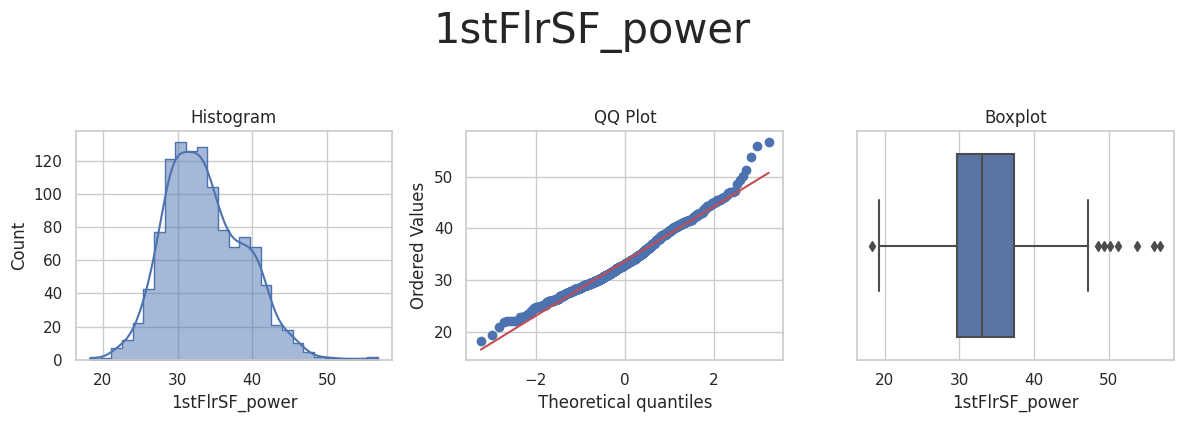

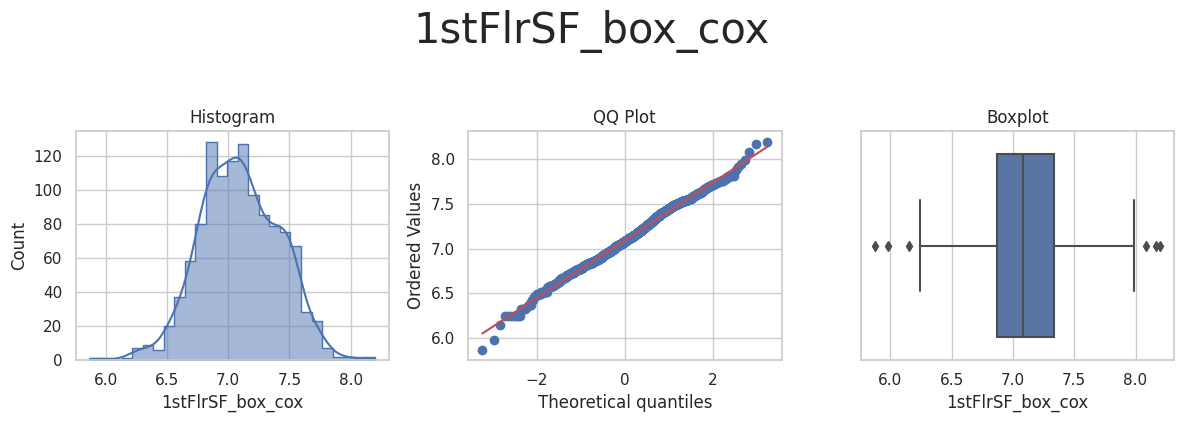

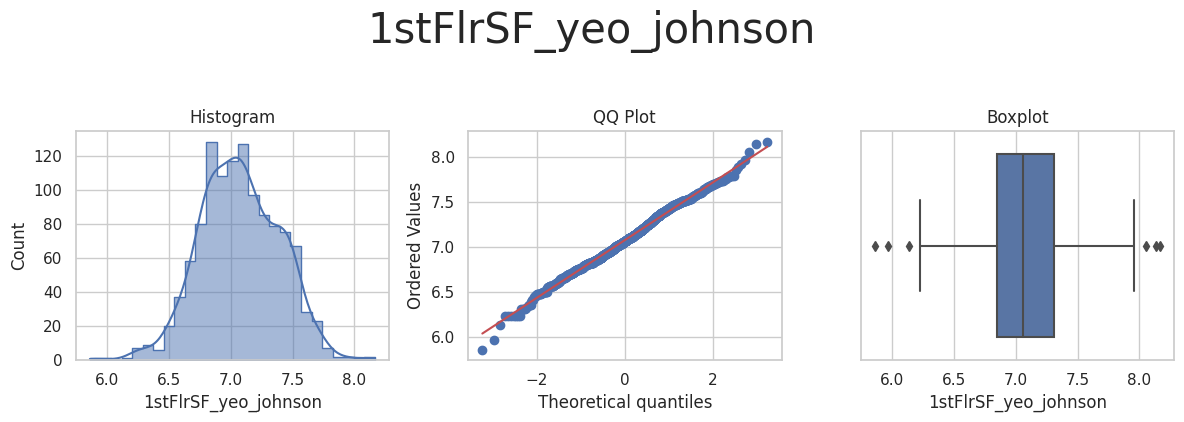



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_power', '2ndFlrSF_yeo_johnson'] 



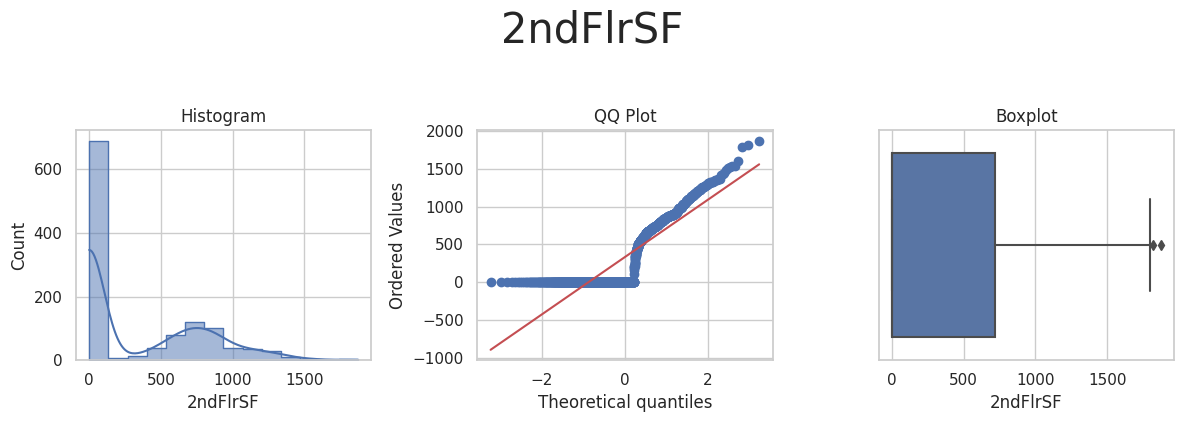

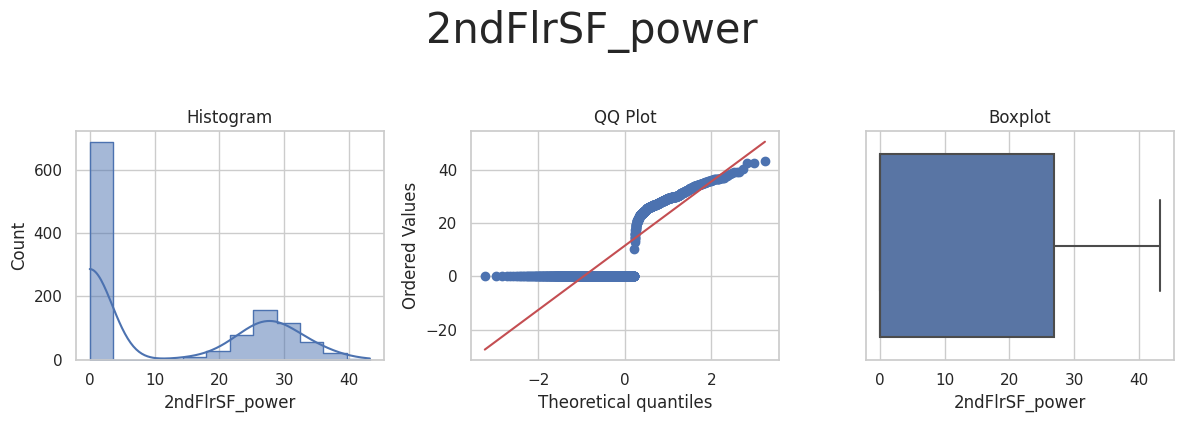

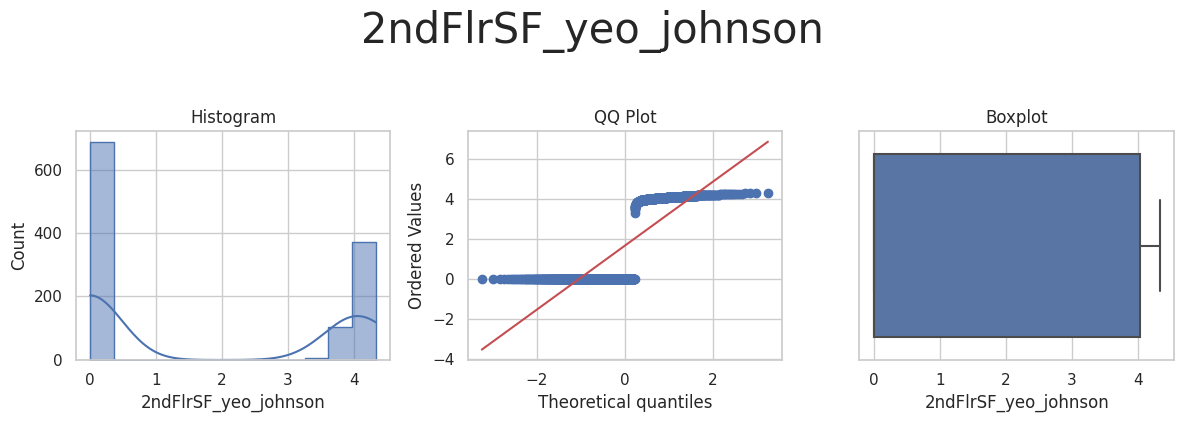

In [ ]:
df_eng = FeatureEngineeringAnalysis(df=df_eng, analysis_type='numerical')

* In addressing the modifications of numerical data, it's noted that the log_e transformation is particularly useful for variables with predominantly large values, effectively reducing the contrast between numerous zero entries and other higher values. This approach will be utilized for 'GrLivArea', 'LotArea', and 'LotFrontage'.

* For the 'TotalSF' variable, similar outcomes are observed with power, Box-Cox, and Yeo-Johnson transformations. Given these comparable effects, the power transformation is selected for its efficacy.

* Regarding several other variables characterized by a significant presence of zeros, transformations yield minimal changes in their overall distributions. However, the power transformation demonstrates a superior capability in normalizing these variables' value ranges. Consequently, this method will be applied to 'GarageArea', 'MasVnrArea', and 'OpenPorchSF'.

In [ ]:
# Initialize Log and Power Transformers for specified variables
log_transformer = vt.LogTransformer(variables=['GrLivArea', 'LotArea', 'LotFrontage'])
power_transformer = vt.PowerTransformer(variables=['GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])

# List of transformers to be applied
transformation_list = [log_transformer, power_transformer]

# Applying each transformation to the TrainSet and TestSet
for transformer in transformation_list:
    TrainSet = transformer.fit_transform(TrainSet)
    TestSet = transformer.fit_transform(TestSet)  

print("* Completion of numerical data transformation process.")

* Completion of numerical data transformation process.


In [ ]:
TrainSet.head()

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  42.755117       0.0      2.883272             0          48             0   
1  29.899833       0.0      2.000000             1           0             0   
2  31.048349       0.0      2.000000             1         713             1   
3  41.097445       0.0      3.000000             1        1218             2   
4  39.255573       0.0      3.000000             1           0             0   

   BsmtUnfSF  GarageArea  GarageFinish  GrLivArea  ...   LotArea  LotFrontage  \
0       1774   27.820855             0   7.510978  ...  9.366831     4.499810   
1        894   17.549929             0   6.795706  ...  8.794825     4.094345   
2        163   20.784610             0   6.871091  ...  9.500020     4.382027   
3        350   29.274562             1   7.431892  ...  9.492884     4.242966   
4       1541   29.034462             1   7.340187  ...  9.525443     4.770685   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0   21.260292    10.392305            5            9    42.684892       2007   
1    0.000000     0.000000            5            5    29.899833       1962   
2    0.000000     0.000000            7            5    29.597297       1921   
3   12.165525     7.681146            5            8    39.597980       2002   
4   12.247449     9.000000            5            7    39.255573       2001   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  
3          2002     271000  
4          2002     205000  

[5 rows x 21 columns]

In [23]:
# Define the columns you want to include in the report
columns_for_report = ['GrLivArea', 'LotArea', 'LotFrontage', 'GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']

# Use .filter() to select these columns
pandas_report = ProfileReport(df=TrainSet.filter(items=columns_for_report), minimal=True)
pandas_report.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Winsoriser

* Winsorizer is a useful tool in data preprocessing, especially when you want to mitigate the effects of outliers without losing valuable data. It helps in making the dataset more uniform and suitable for techniques that might be sensitive to extreme values.

* We start as before by selecting variables, this time we select the variables with potential outliers.

In [24]:
wins_var = ['GarageArea',
            'LotArea',
            'LotFrontage',
            'MasVnrArea',
            'OpenPorchSF',
            'TotalBsmtSF',
            '1stFlrSF',
            '2ndFlrSF']

wins_var

['GarageArea',
 'LotArea',
 'LotFrontage',
 'MasVnrArea',
 'OpenPorchSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF']

* As before we create a separete dataframe

In [25]:
df_eng = TrainSet[wins_var].copy()
df_eng.head()

GarageArea   LotArea  LotFrontage  MasVnrArea  OpenPorchSF  TotalBsmtSF  \
0   27.820855  9.366831     4.499810   21.260292    10.392305    42.684892   
1   17.549929  8.794825     4.094345    0.000000     0.000000    29.899833   
2   20.784610  9.500020     4.382027    0.000000     0.000000    29.597297   
3   29.274562  9.492884     4.242966   12.165525     7.681146    39.597980   
4   29.034462  9.525443     4.770685   12.247449     9.000000    39.255573   

    1stFlrSF  2ndFlrSF  
0  42.755117       0.0  
1  29.899833       0.0  
2  31.048349       0.0  
3  41.097445       0.0  
4  39.255573       0.0

* We use the transformitions to create engineered variables we then asses the variables and selects the most sutible method as we did before

* Variable Analyzed: GarageArea
* Applied transformation: ['GarageArea_iqr'] 



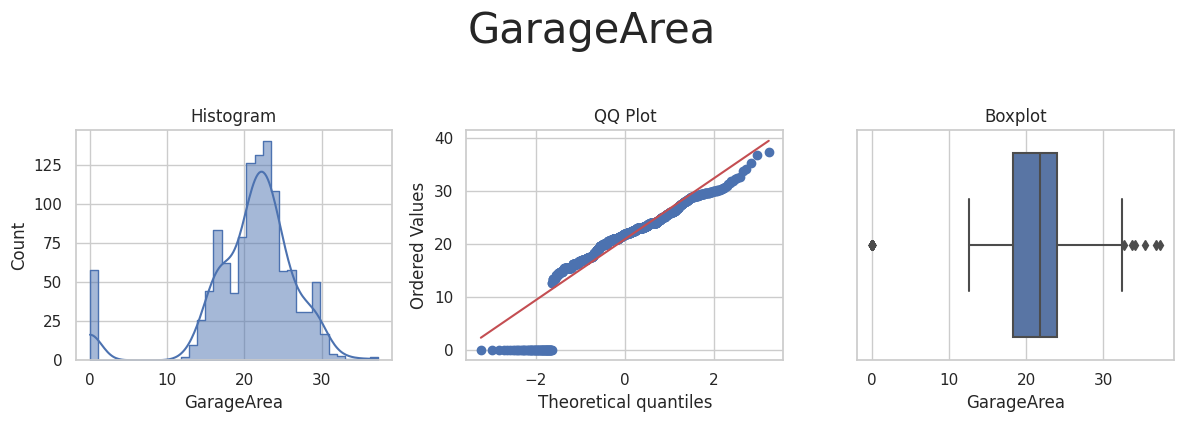

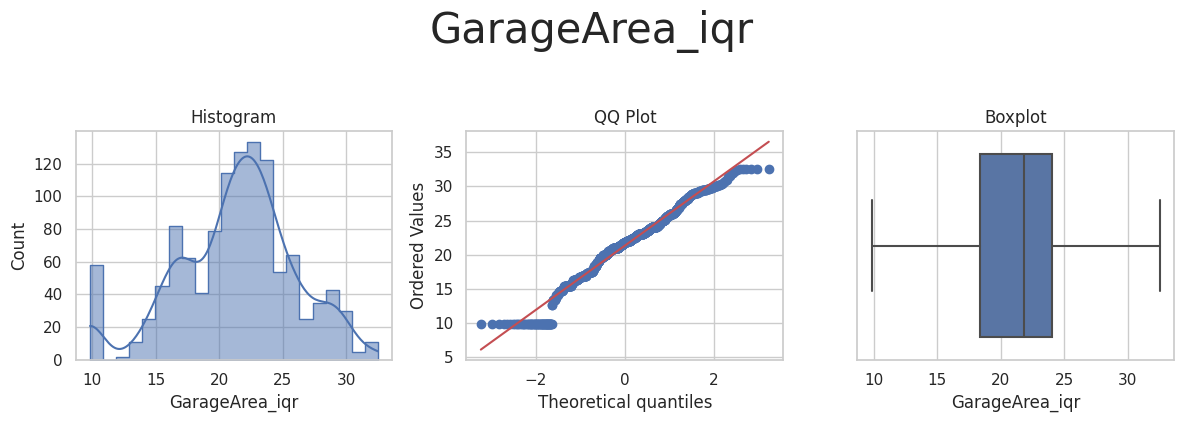



* Variable Analyzed: LotArea
* Applied transformation: ['LotArea_iqr'] 



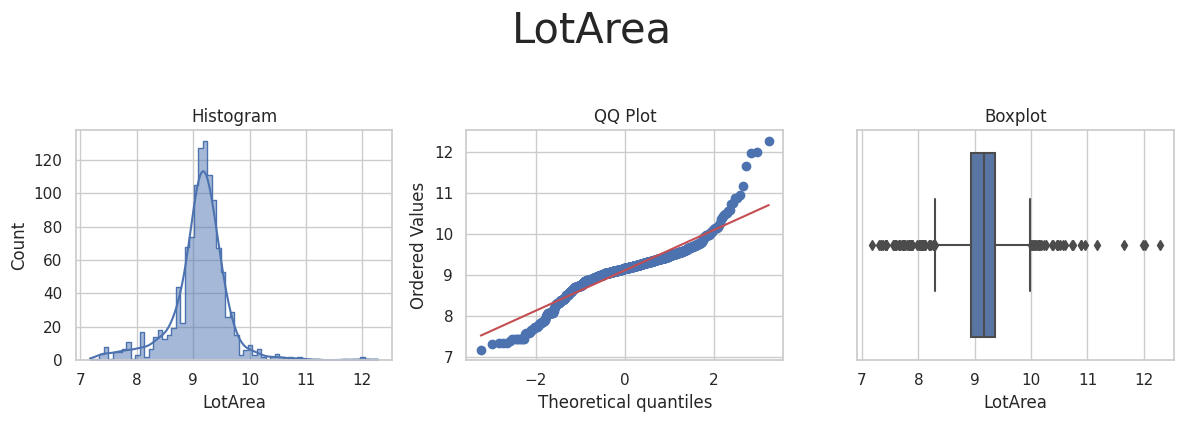

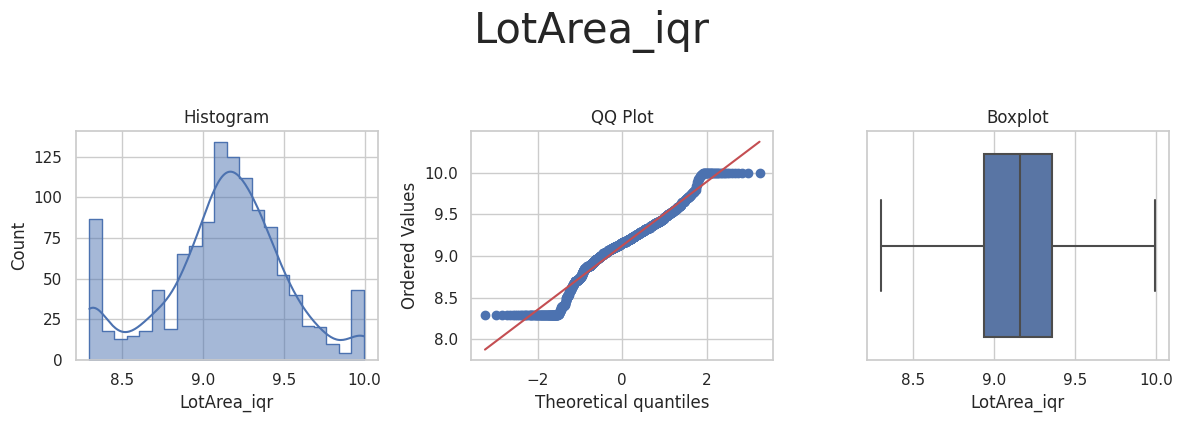



* Variable Analyzed: LotFrontage
* Applied transformation: ['LotFrontage_iqr'] 



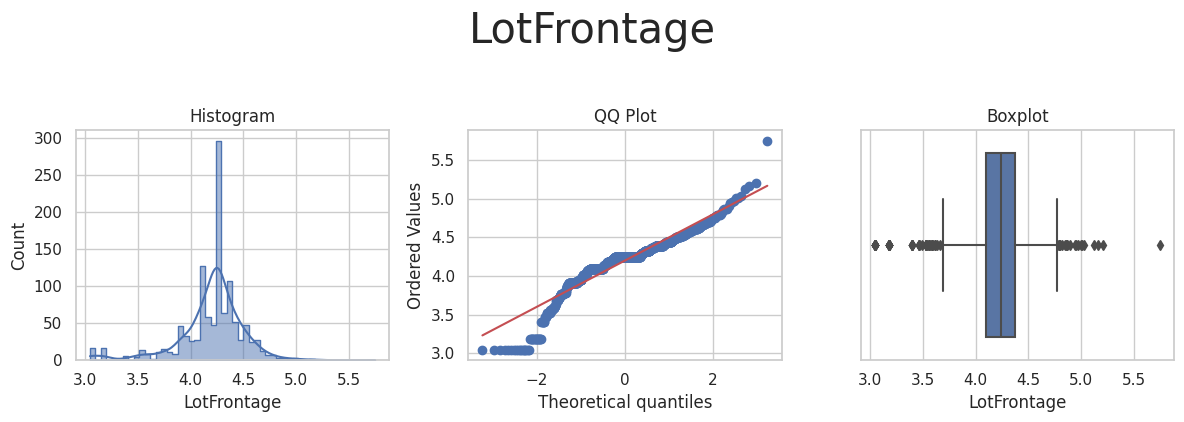

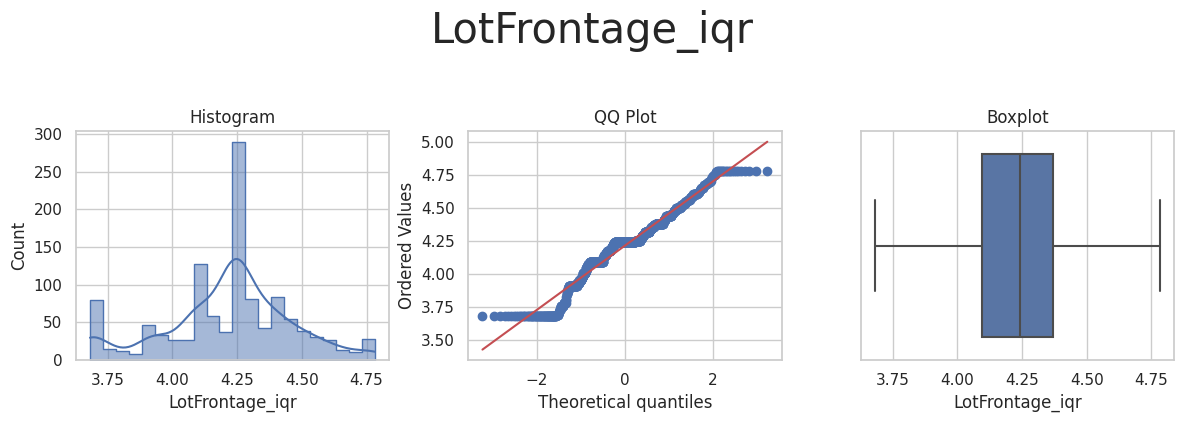



* Variable Analyzed: MasVnrArea
* Applied transformation: ['MasVnrArea_iqr'] 



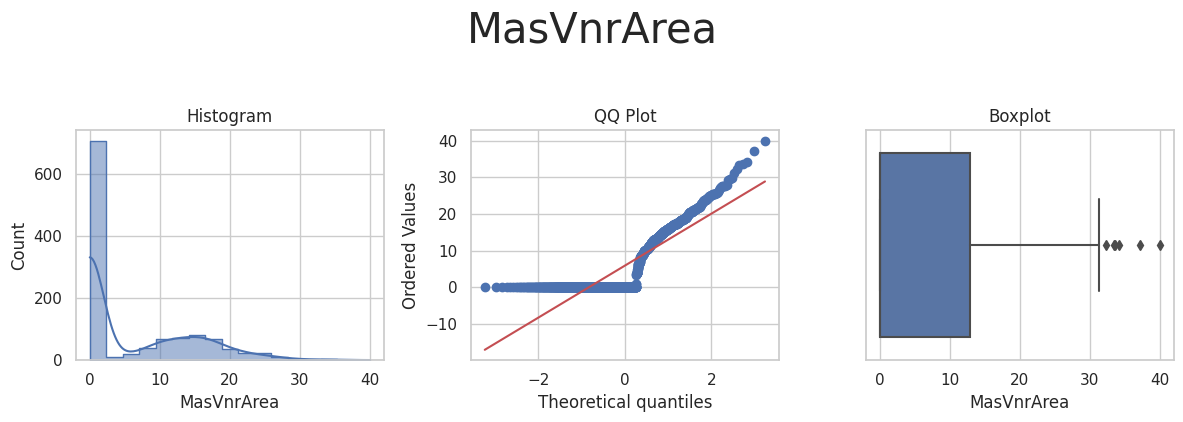

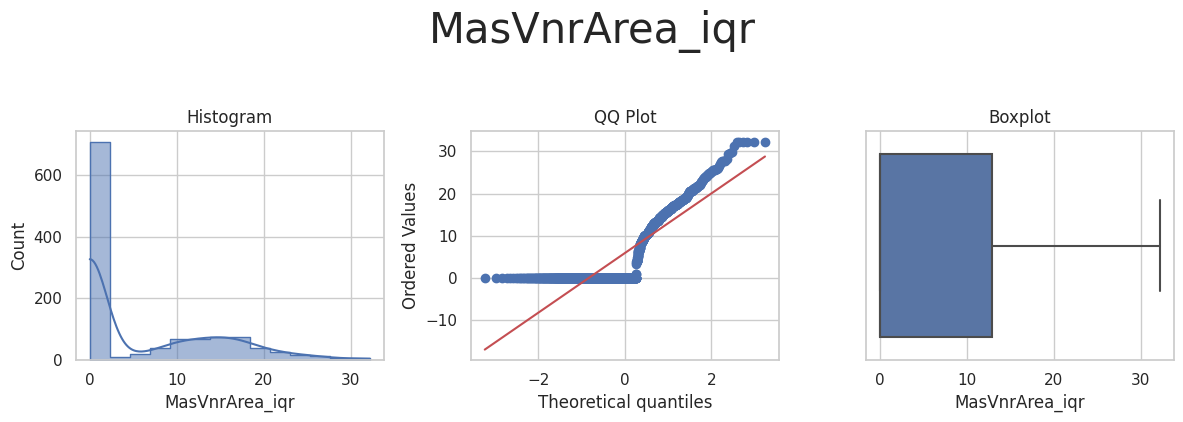



* Variable Analyzed: OpenPorchSF
* Applied transformation: ['OpenPorchSF_iqr'] 



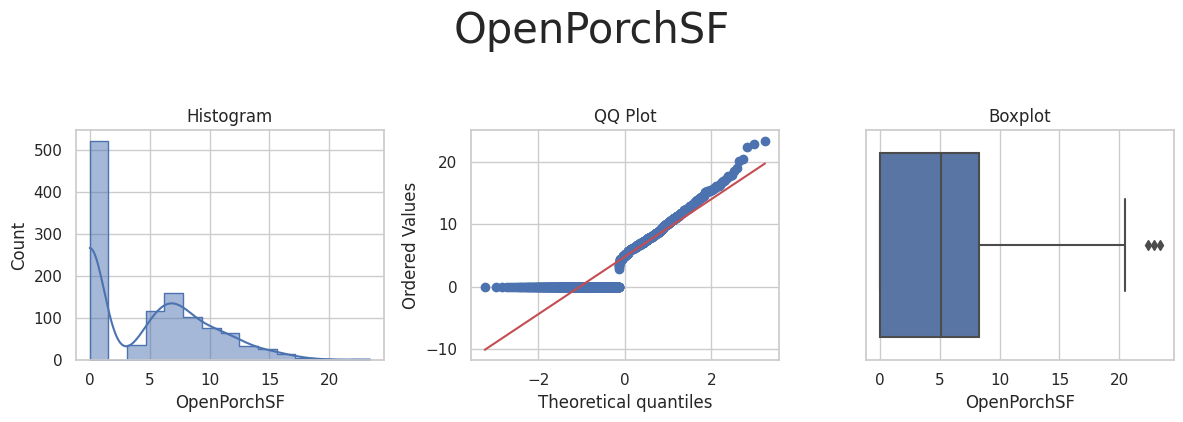

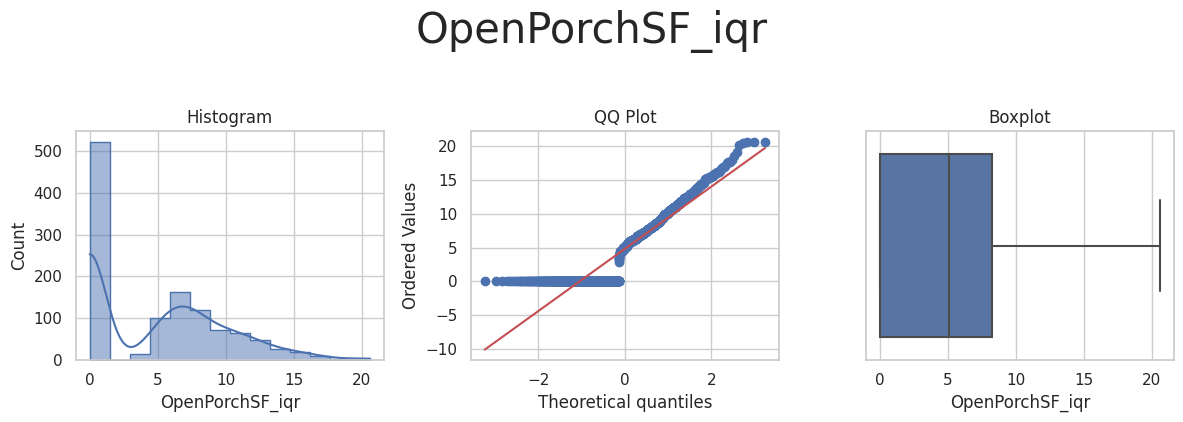



* Variable Analyzed: TotalBsmtSF
* Applied transformation: ['TotalBsmtSF_iqr'] 



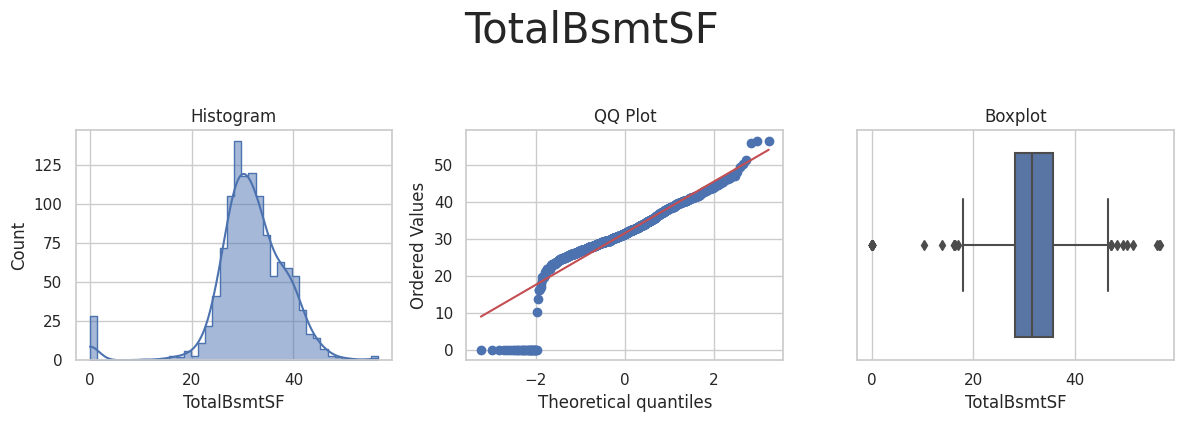

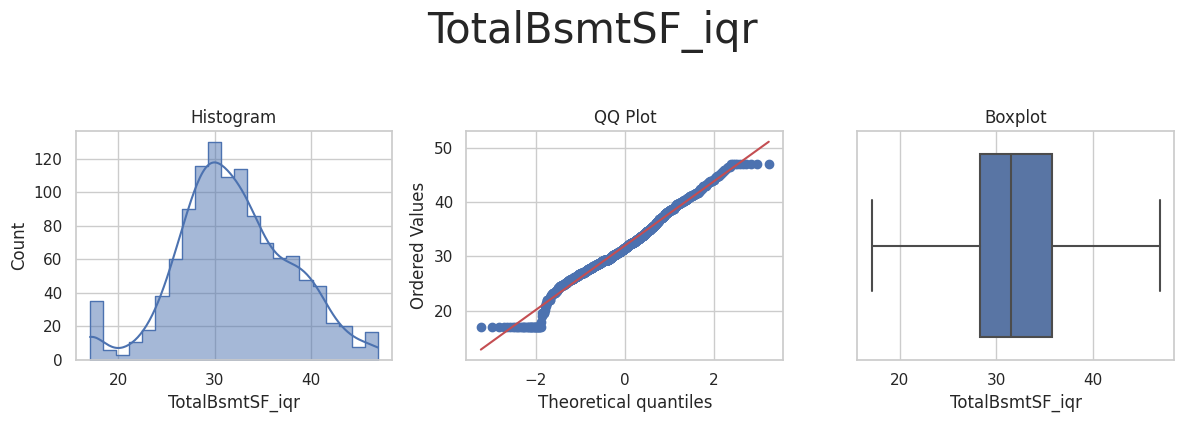



* Variable Analyzed: 1stFlrSF
* Applied transformation: ['1stFlrSF_iqr'] 



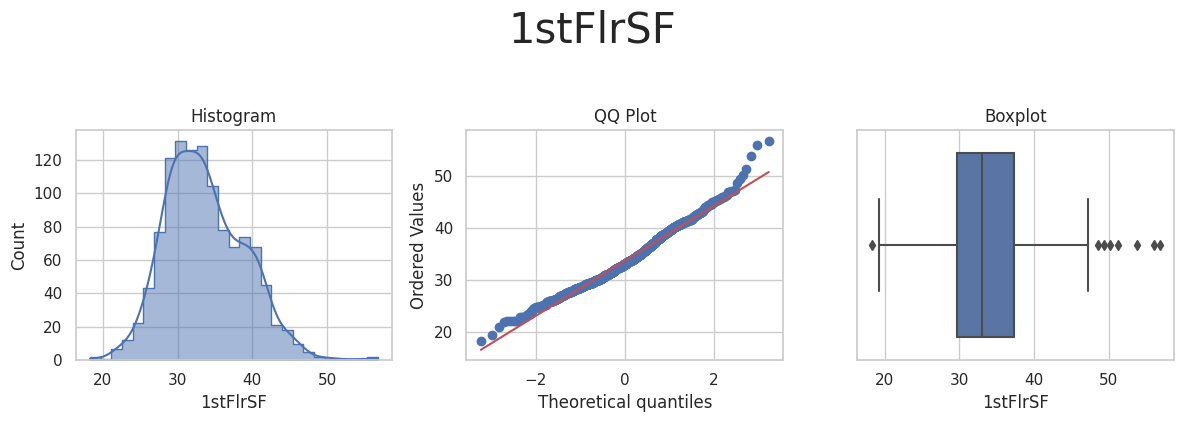

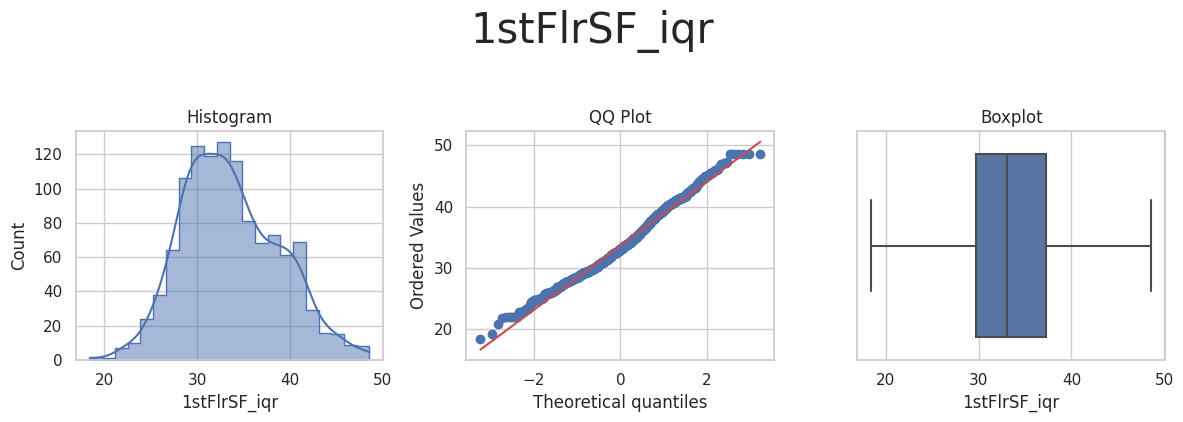



* Variable Analyzed: 2ndFlrSF
* Applied transformation: ['2ndFlrSF_iqr'] 



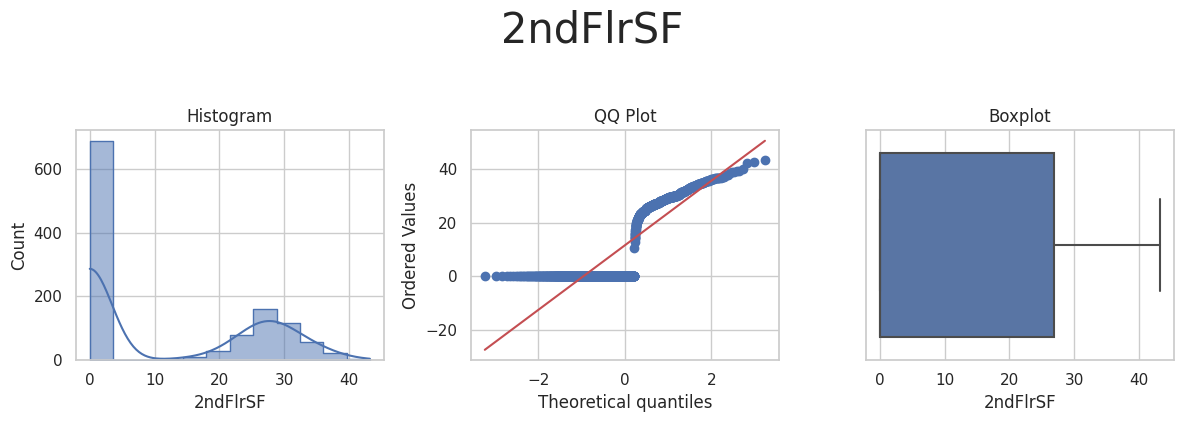

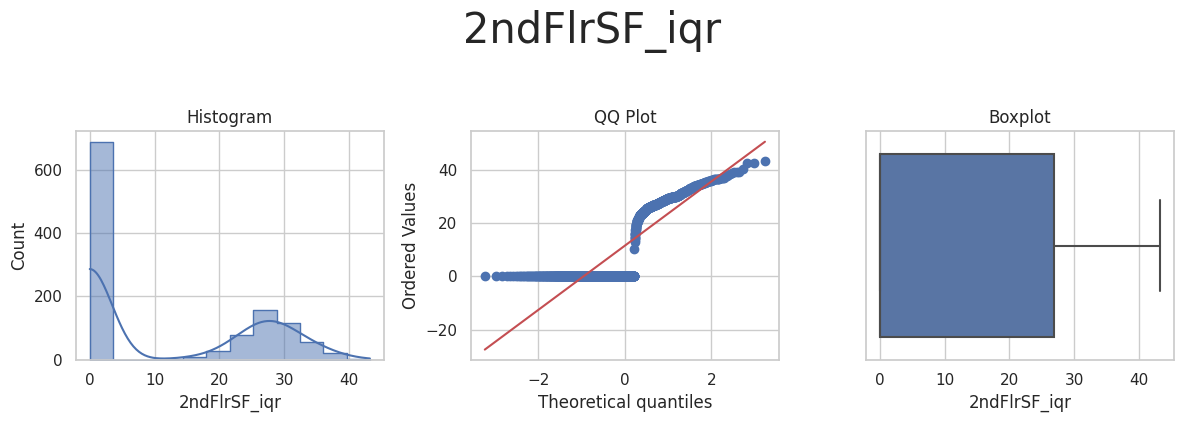

In [26]:
df_eng = FeatureEngineeringAnalysis(df=df_eng, analysis_type='outlier_winsorizer')

* As a las step and as we done before we need to apply the winsoriser to the train/test set

In [27]:
# Initializing the Winsorizer for handling outliers in selected variables
outlier_handler = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=wins_var)

# Applying the Winsorizer to the training dataset
TransformedTrainSet = outlier_handler.fit_transform(TrainSet)

# Applying the transformation learned from the training set to the test set
TransformedTestSet = outlier_handler.fit_transform(TestSet)

print("* Completion of outlier handling with Winsorizer.")

* Completion of outlier handling with Winsorizer.


### SmartCorrelatedSelection Variables

In [28]:
from feature_engine.selection import SmartCorrelatedSelection
smart_corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

smart_corr_sel.fit_transform(df_eng)
smart_corr_sel.correlated_feature_sets_

[{'GarageArea', 'GarageArea_iqr'},
 {'LotArea', 'LotArea_iqr'},
 {'LotFrontage', 'LotFrontage_iqr'},
 {'MasVnrArea', 'MasVnrArea_iqr'},
 {'OpenPorchSF', 'OpenPorchSF_iqr'},
 {'1stFlrSF', '1stFlrSF_iqr', 'TotalBsmtSF', 'TotalBsmtSF_iqr'},
 {'2ndFlrSF', '2ndFlrSF_iqr'}]

In [29]:
smart_corr_sel.features_to_drop_

['GarageArea_iqr',
 'LotArea_iqr',
 'LotFrontage_iqr',
 'MasVnrArea_iqr',
 'OpenPorchSF_iqr',
 'TotalBsmtSF_iqr',
 '1stFlrSF',
 '1stFlrSF_iqr',
 '2ndFlrSF_iqr']

In [30]:
df_eng = TrainSet.copy()
df_eng.head(3)

1stFlrSF  2ndFlrSF  BedroomAbvGr  BsmtExposure  BsmtFinSF1  BsmtFinType1  \
0  42.755117       0.0      2.883272             0          48             0   
1  29.899833       0.0      2.000000             1           0             0   
2  31.048349       0.0      2.000000             1         713             1   

   BsmtUnfSF  GarageArea  GarageFinish  GrLivArea  ...   LotArea  LotFrontage  \
0       1774   27.820855             0   7.510978  ...  9.366831     4.499810   
1        894   17.549929             0   6.795706  ...  8.794825     4.094345   
2        163   20.784610             0   6.871091  ...  9.500020     4.382027   

   MasVnrArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0   21.260292    10.392305            5            9    42.684892       2007   
1    0.000000     0.000000            5            5    29.899833       1962   
2    0.000000     0.000000            7            5    29.597297       1921   

   YearRemodAdd  SalePrice  
0          2007     314813  
1          1962     109500  
2          2006     163500  

[3 rows x 21 columns]

---

# Conclusions and Next Steps

* Transformations in Feature Engineering:

* Ordinal Encoding for Categorical Variables: Applied to 'BsmtExposure', 'BsmtFinType1', 'GarageFinish', and 'KitchenQual'.

* Transformations for Numerical Data: Implemented on 'GrLivArea', 'LotArea', 'LotFrontage', along with 'GarageArea', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', and '2ndFlrSF'.

* Outlier Management via Winsorizing: Targeted at 'GarageArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', and '2ndFlrSF'.